<a href="https://colab.research.google.com/github/michelleaeh/ADissertation/blob/master/34MScCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** MSc in Robotics and Intelligent Systems Dissertation

**Author:** Michelle Alejandra Espinosa Hernandez

**Student registration number:** 1900964

**Student PRID:** ESPIN62803

**Date:** September 2020 

**Purpose:** Obtain classification accuracy among different types of sensors and different data processing steps

# **Data description**

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.

Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.

The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL

If you use this dataset please cite the following papers:

@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}

@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns

**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM


# **Variable definition**

In [1]:
numreps=34      # Number of epochs per word
num_trials=10  # Number of runs of cross validation


# **1. Preparation of data**

**1.1. Start up and initialization of variables**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import random
import scipy as sp
import time
import warnings

from collections import Counter
from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

**1.2. Initialization of variables**

In [3]:
# Start timer
starttime = time.time()

# Eliminate warnings
warnings.filterwarnings("ignore")

# Extract all files from zip
with ZipFile("/content/2MyoASL.zip", 'r') as zip:
  zip.extractall()

# Division of sensors
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
     'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
colnames=emg[:8]+acc[:3]+gyro[:3]+ori[:3]+emg[8:]+acc[3:]+gyro[3:]+ori[3:]

# Words
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']

# Generation of matrices
### Combinations of sensors (E=emg=3, A=acc=5, G=gyro=7, O=ori=11)
comb=['E', 'A', 'G', 'O', 'EA', 'EG', 'EO', 'AG', 'AO', 'GO', 'EAG', 'EAO', 'EGO', 'AGO', 'EAGO'] 
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155] 
### Combinations of steps (N=Normalization=3, S=Standardization=5, B=Butterworth=7, P=PCA=11, V=SVM=13)
nsteps=['V', 'NV', 'SV', 'BV', 'PV', 'NBV', 'NPV', 'SBV', 'SPV', 'BPV', 'NBPV', 'SBPV'] 
steps=[13, 39, 65, 91, 143, 273, 429, 455, 715, 1001, 3003, 5005] 
### Placeholders
fresults=np.zeros((len(steps),len(products)))
params=np.zeros((len(steps),len(products)))
headers=np.empty(1701, dtype=object)
lengths=np.zeros(849, dtype=int)
repsum=np.zeros(37,dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)
fn=np.arange(1701)
matrix=np.zeros(1)
stanproducts=[]
normproducts=[]
regproducts=[]
cmatrix=[]

# Initiation of counters
wordnum=-1
counter=-1
rownum=-1
start=0
num=0
n=0

**1.3. Combine all files**

In [4]:
for w in words:
  repcount=0
  wordnum+=1
  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'
    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      trial.reset_index(drop=True)
      
      # Assign word number to each row and make data horizontal
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

  reps[wordnum]=repcount
  if wordnum>0:
    repsum[wordnum]=reps[wordnum-1]+repsum[wordnum-1]
    repsum[36]=849

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
matrix=pd.concat([matrix['Word'],matrix[emg],matrix[acc],matrix[gyro],matrix[ori]],axis=1)
exec("matrix.to_csv(path_or_buf='/content/complete_matrix_'+str(numreps)+'.csv')")
print('Reps of each word:',reps)
print('Cummulative reps:',repsum)

Reps of each word: [19 24 32 20 24 20 19 31 24 29 20 21 23 33 34 18 27 24 35 19 17 34 30 19
 22 21 23 27 27  4 20 19 20 20 21 29]
Cummulative reps: [  0  19  43  75  95 119 139 158 189 213 242 262 283 306 339 373 391 418
 442 477 496 513 547 577 596 618 639 662 689 716 720 740 759 779 799 820
 849]


**1.4. Calculate mean and standard deviation of each sensor and each file**

In [5]:
# Average and standard deviation of each sensor in each file
for s in colnames:
  avg=matrix[s].mean(axis=1)
  sd=matrix[s].std(axis=1)
  sensor=pd.concat([avg.rename(s+': Mean_'),sd.rename('St. dev.')], axis=1)
  if s=='EMG0L':
    asd=sensor
  else:
    asd=pd.concat([asd, sensor], axis=1)
print('Average and standard deviation of each sensor per file')
print(asd)

# Average and standard deviation of each file
avg=matrix.mean(axis=1)
sd=matrix.std(axis=1)
print('Average and standard deviation of each file')
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

Average and standard deviation of each sensor per file
     EMG0L: Mean_   St. dev.  EMG1L: Mean_  ...   St. dev.  OYR: Mean_   St. dev.
0           -2.32   8.664825         -0.80  ...  28.427609       86.70  10.529356
1           -1.80   9.544739         -4.08  ...  27.821010       85.68   6.579002
2           -3.16  13.085839         -2.32  ...  30.345736       91.88  17.358924
3           -0.82  10.123099         -3.16  ...  29.645002       88.46  12.969682
4           -0.50   6.516071          2.76  ...  13.237239      116.58  18.099600
..            ...        ...           ...  ...        ...         ...        ...
844          0.56   7.754288          0.22  ...  17.236281      104.76   7.528341
845         -1.74   6.520955         -1.20  ...  21.772891       69.66  85.251036
846          1.02   7.731436          0.46  ...  22.707735       56.76  79.408415
847          0.06   5.582078          2.36  ...  23.650422       71.62  84.238701
848         -2.22   7.434860         -1.62 

,Mean,St. dev.
0,15.256437,46.545832
1,14.220110,47.316822
2,15.441784,45.614456
3,13.651092,47.038916
4,15.063294,49.105612
...,...,...
844,13.167964,41.642351
845,13.815314,42.880121
846,12.970618,42.725653
847,13.852317,43.758631


# **2. Data adjustement**

**2.1. Establish equal number of epochs per word**

In [6]:
for i in range(len(reps)-1,-1,-1):
  if reps[i]<numreps:
    for r in range(len(matrix)-1,-1,-1):
      if int(matrix.iloc[r]['Word'])==i:
        matrix=matrix.drop(r)
  elif reps[i]>numreps:
    elim=random.sample(range(repsum[i],repsum[i+1]),reps[i]-numreps)
    matrix=matrix.drop(elim)

exec("matrix.to_csv(path_or_buf='/content/equal_matrix_'+str(numreps)+'.csv')")

**2.2. Create sensor combinatory matrices: unaltered, normalized, and standardized**

In [7]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  fnword=[]
  fsword=[]
  m=matrix.copy()
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word']   # Features

  # Create column of words instead of numbers
  wordcol=np.empty(len(m), dtype=object)
  z=0
  wcol=[int(i) for i in m['Word'].values]
  for f in wcol:
    wordcol[z]=words[f]
    z+=1
  wordcol=np.asmatrix(wordcol)
  regular=np.concatenate((np.transpose(wordcol),np.copy(m.iloc[:,1:])),axis=1)
  inputmatrix=pd.DataFrame(regular,columns=m.columns).dropna(axis=1)
  regproducts.append(inputmatrix)

  for pr in range(len(inputmatrix)):
    nemg=[]
    nacc=[]
    ngyro=[]
    nori=[]
    norm=[]
    semg=[]
    sacc=[]
    sgyro=[]
    sori=[]
    stan=[]
    if emg[0] in inputmatrix:
      in_emg=inputmatrix.iloc[pr][emg]
      nemg=(in_emg-in_emg.min())/(in_emg.max()-in_emg.min())
      is_emg=inputmatrix.iloc[pr][emg].values
      is_emg=is_emg[np.newaxis]
      semg=StandardScaler().fit_transform(np.transpose(is_emg))
      semg=semg.reshape(-1)
    if acc[0] in inputmatrix:
      in_acc=inputmatrix.iloc[pr][acc]
      nacc=(in_acc-in_acc.min())/(in_acc.max()-in_acc.min())
      is_acc=inputmatrix.iloc[pr][acc].values
      is_acc=is_acc[np.newaxis]
      sacc=StandardScaler().fit_transform(np.transpose(is_acc))
      sacc=sacc.reshape(-1)
    if gyro[0] in inputmatrix:
      in_gyro=inputmatrix.iloc[pr][gyro]
      ngyro=(in_gyro-in_gyro.min())/(in_gyro.max()-in_gyro.min())
      is_gyro=inputmatrix.iloc[pr][gyro].values
      is_gyro=is_gyro[np.newaxis]
      sgyro=StandardScaler().fit_transform(np.transpose(is_gyro))
      sgyro=sgyro.reshape(-1)
    if ori[0] in inputmatrix:
      in_ori=inputmatrix.iloc[pr][ori]
      nori=(in_ori-in_ori.min())/(in_ori.max()-in_ori.min())
      is_ori=inputmatrix.iloc[pr][ori].values
      is_ori=is_ori[np.newaxis]
      sori=StandardScaler().fit_transform(np.transpose(is_ori))
      sori=sori.reshape(-1)
    
    ## Normalize each type of sensor per sample between 0 and 1
    norm=np.concatenate((np.transpose(nemg),np.transpose(nacc),np.transpose(ngyro),np.transpose(nori)))
    norm=norm[np.newaxis]
    fnword=np.append(fnword,norm)
    fnword=fnword[np.newaxis]
    
    ## Standardize each type of sensor with mean=0 and deviation=1
    stan=np.concatenate((np.transpose(semg),np.transpose(sacc),np.transpose(sgyro),np.transpose(sori)))
    stan=stan[np.newaxis]
    fsword=np.append(fsword,stan)
    fsword=fsword[np.newaxis]

  nmx=np.reshape(fnword,(len(inputmatrix),len(inputmatrix.columns)-1))
  norm_matrix=np.concatenate((np.transpose(wordcol),nmx),axis=1) 
  norm_matrix=pd.DataFrame(norm_matrix,columns=inputmatrix.columns)
  normproducts.append(norm_matrix)
  exec("norm_matrix.to_csv(path_or_buf='/content/norm_matrix_'+str(numreps)+'.'+str(v)+'.csv')")

  smx=np.reshape(fsword,(len(inputmatrix),len(inputmatrix.columns)-1))
  stan_matrix=np.concatenate((np.transpose(wordcol),smx),axis=1) 
  stan_matrix=pd.DataFrame(stan_matrix,columns=inputmatrix.columns)
  stanproducts.append(stan_matrix)
  exec("stan_matrix.to_csv(path_or_buf='/content/stan_matrix_'+str(numreps)+'.'+str(v)+'.csv')")


# **3. Definition of functions for steps**

**3.1. Split data into train and test sets**

In [8]:
def datasplit(inmatrix_p):
    x = inmatrix_p.iloc[:, inmatrix_p.columns!='Word']   # Features
    y = inmatrix_p.loc[:,'Word']                         # Target
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x, y, test_size=0.3)
    return x_train_p, x_test_p, y_train_p, y_test_p

**3.2. Butterworth**

In [9]:
def butterworth(inmatrix_b):
  fs_nyq=50/2
  b, a = sp.signal.butter(8, 20/fs_nyq, btype='highpass', fs=fs_nyq)
  if emg[0] in inmatrix_b:
    for r in range(len(inmatrix_b)):
      in_emg=inmatrix_b.iloc[r][emg].values
      emg_filtered = sp.signal.lfilter(b, a, in_emg)
      emg_filtered=emg_filtered[np.newaxis]
      inmatrix_b.iloc[r,1:len(np.transpose(emg_filtered))+1]=emg_filtered
  return inmatrix_b

**3.3. PCA**

In [10]:
def pca(x_train_c, x_test_c, y_train_c, y_test_c):
  labels=list(dict.fromkeys(x_train_c.columns))
  for rmx in range(len(x_train_c)):
    for lmx in labels:
      inr=x_train_c.iloc[rmx][lmx]
      inr=inr.array
      inr=np.transpose(inr[np.newaxis])
      if labels[0]==lmx:
        nrow=inr
      else:
        nrow=np.concatenate((nrow,inr),axis=1)
    if rmx==0:
      trainrow=nrow
    else:
      trainrow=np.concatenate((trainrow,nrow))

  for rmx in range(len(x_test_c)):
    for lmx in labels:
      inr=x_test_c.iloc[rmx][lmx]
      inr=inr.array
      inr=np.transpose(inr[np.newaxis])
      if labels[0]==lmx:
        nrow=inr
      else:
        nrow=np.concatenate((nrow,inr),axis=1)
    if rmx==0:
      testrow=nrow
    else:
      testrow=np.concatenate((testrow,nrow))
    
  pca = PCA(n_components=0.9, svd_solver='full')
  pca.fit(trainrow)
  t_train = pca.transform(trainrow)
  t_test = pca.transform(testrow)

  step=int(len(t_train)/len(x_train_c))
  for rc in range(len(t_train[0])):
    for rm in range(0,len(t_train)-step+1,step):
      inc=t_train[rm:rm+step,rc]
      inc=np.transpose(inc)
      if rm==0:
        ncol=inc
      else:
        ncol=np.concatenate((ncol,inc))
    if rc==0:
      x_t_train_pca=ncol
    else:
      x_t_train_pca=np.concatenate((x_t_train_pca,ncol))

  x_t_train_pca=x_t_train_pca[np.newaxis]
  x_t_train_pca=np.reshape(x_t_train_pca,(len(x_train_c),step*len(t_train[0])))

  tstep=int(len(t_test)/len(x_test_c))
  for rc in range(len(t_test[0])):
    for rm in range(0,len(t_test)-tstep+1,tstep):
      inc=t_test[rm:rm+tstep,rc]
      inc=np.transpose(inc)
      if rm==0:
        ncol=inc
      else:
        ncol=np.concatenate((ncol,inc))
    if rc==0:
      x_t_test_pca=ncol
    else:
      x_t_test_pca=np.concatenate((x_t_test_pca,ncol))

  x_t_test_pca=x_t_test_pca[np.newaxis]
  x_t_test_pca=np.reshape(x_t_test_pca,(len(x_test_c),tstep*len(t_test[0])))
  print(x_train_c)
  print(t_train)
  print(x_t_train_pca)

  return x_train_c, x_test_c, y_train_c, y_test_c, x_t_train_pca, x_t_test_pca

**3.4. SVM with Grid Search**

In [11]:
def svm(x_train_s, x_test_s, y_train_s, y_test_s, x_t_train_s, x_t_test_s,combo):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100, 1000]}
    svc = SVC(max_iter=1000)
    nested_scores=np.zeros(num_trials)
    for t in range(num_trials):
      inner_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      outer_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      #clf=GridSearchCV(svc,parameters,scoring='accuracy',n_jobs=1,cv=outer_cv)
      clf=svc
      clf.fit(x_t_train_s, y_train_s)
      nested_scores=cross_val_score(clf,x_t_test_s,y_test_s,cv=outer_cv)
      nested_scores[i]=nested_scores.mean()
    y_pred=clf.predict(x_t_test_s)
    
    # Confusion matrix
    plot_confusion_matrix(clf, x_t_test_s, y_test_s, cmap=plt.cm.Blues)
    plt.title(combo)
    plt.show()

    #bestpar=clf.best_params_
    accuracy=nested_scores.mean()
    svmresult=classification_report(y_test_s, y_pred)
    #return svmresult,accuracy, bestpar
    return svmresult,accuracy

# **4. Main code**

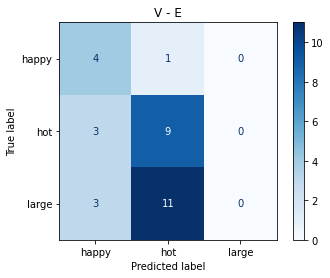

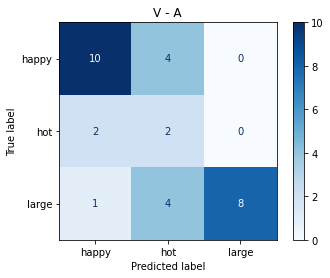

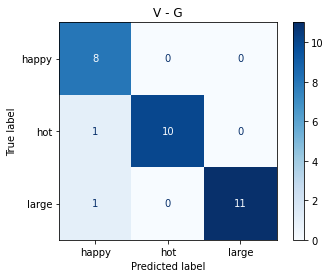

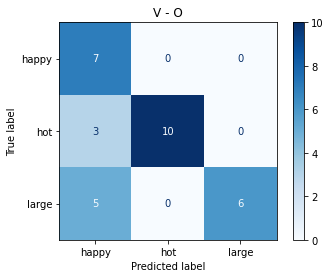

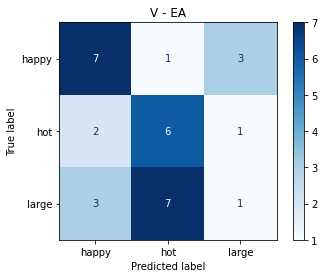

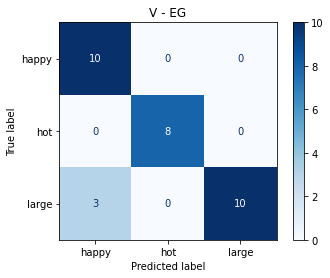

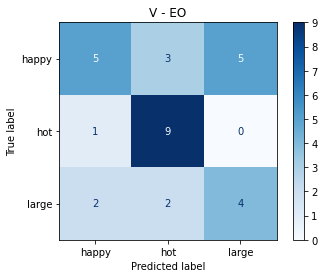

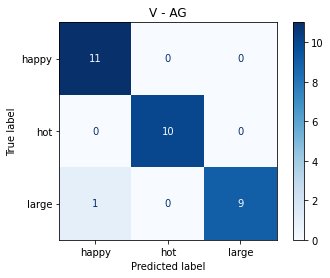

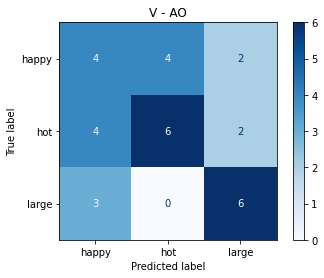

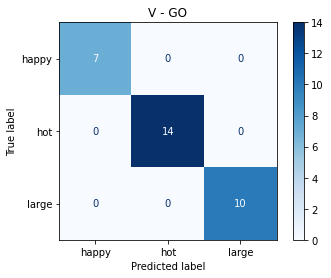

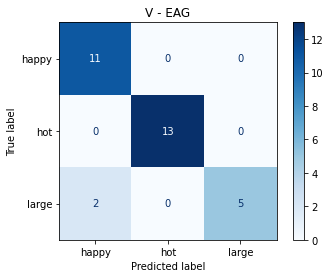

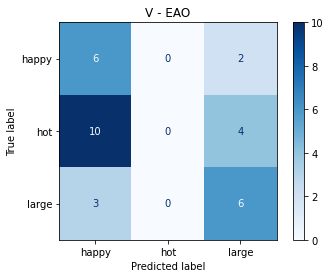

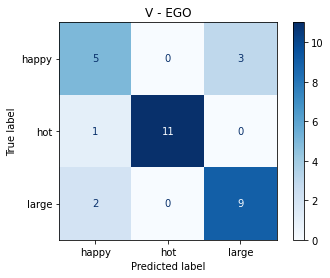

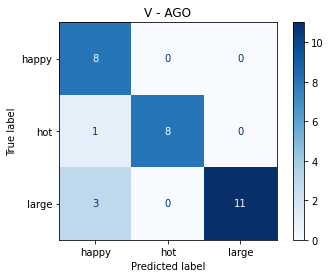

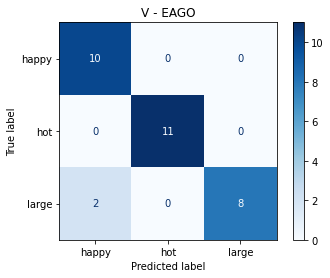

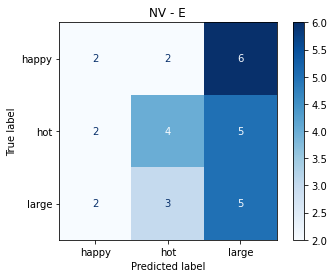

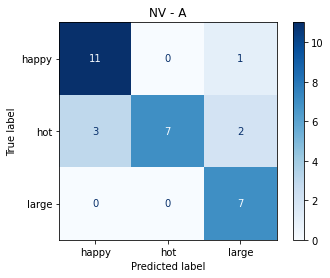

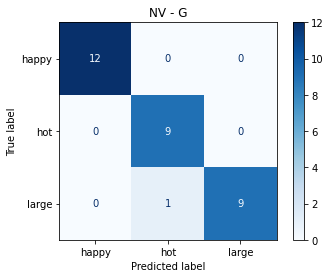

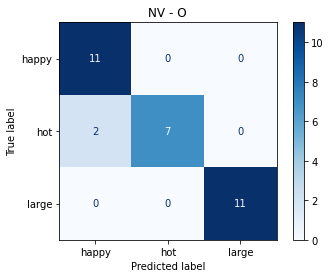

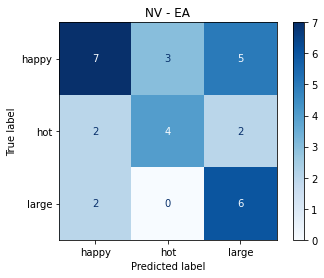

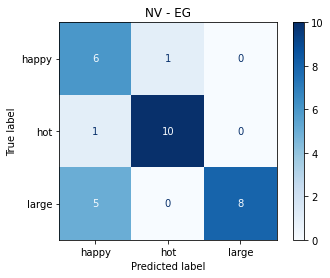

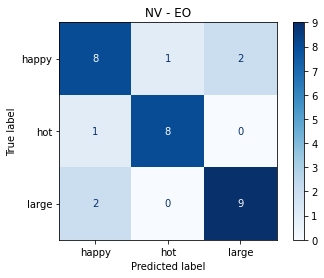

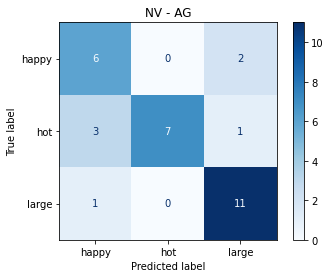

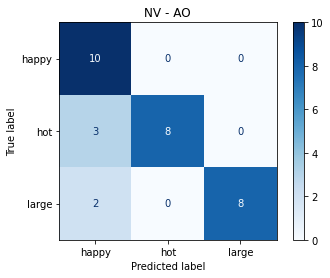

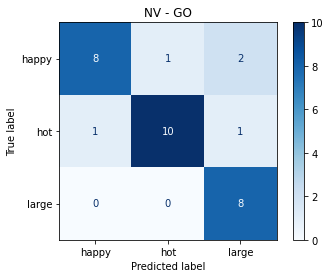

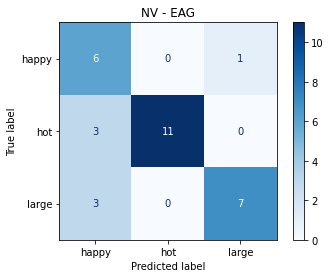

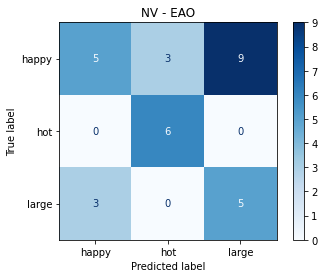

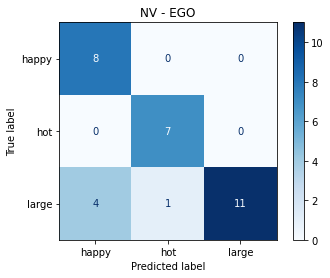

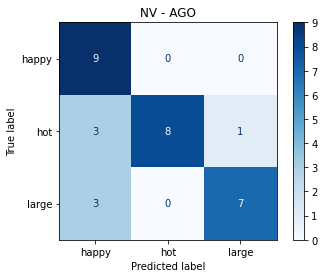

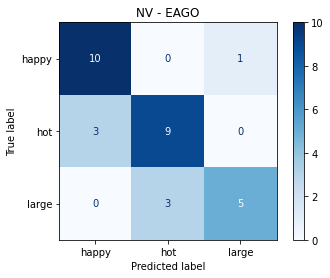

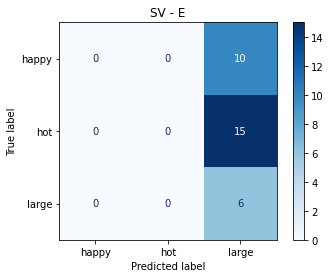

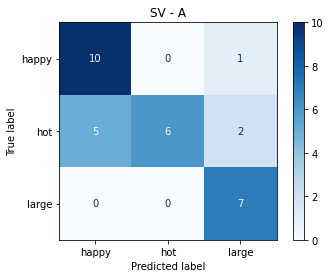

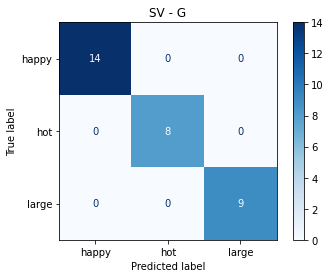

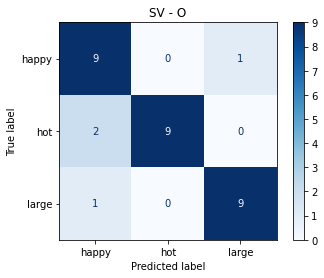

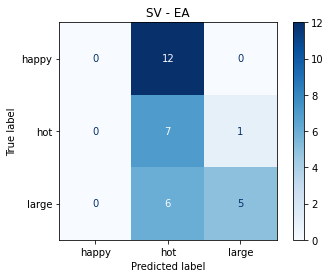

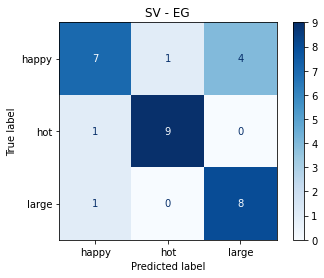

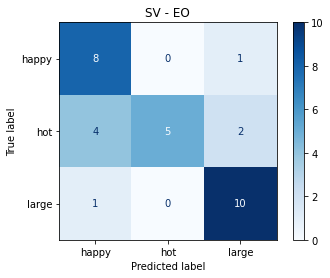

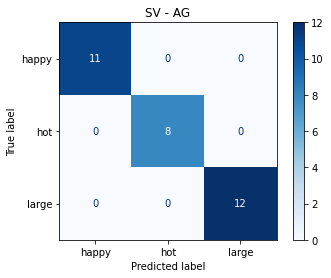

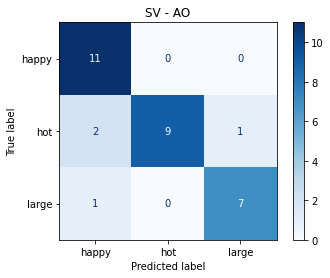

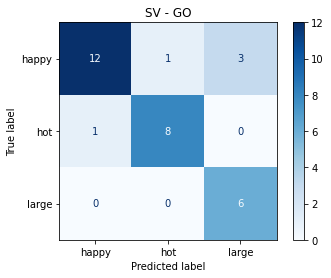

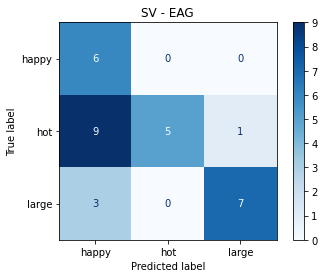

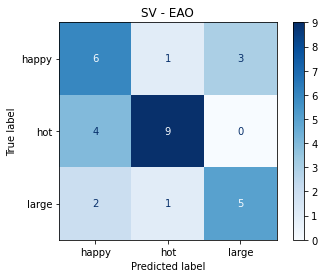

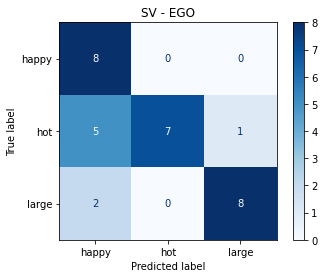

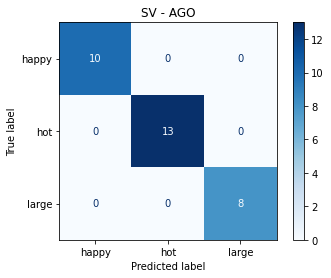

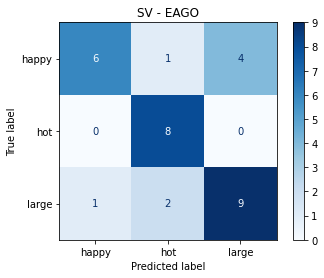

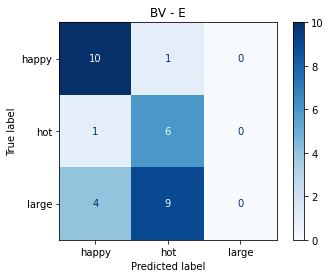

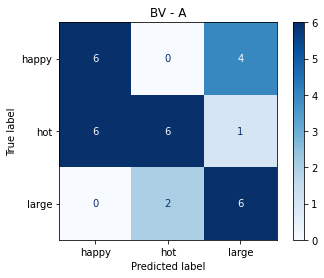

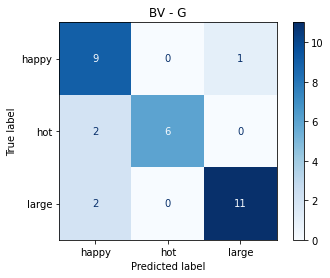

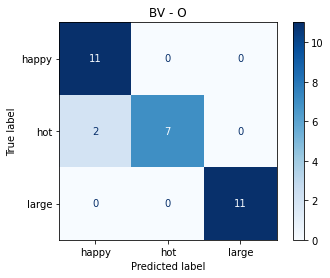

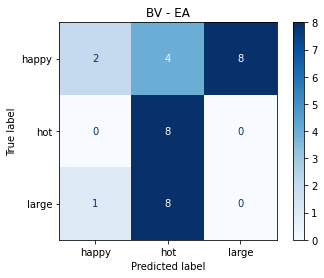

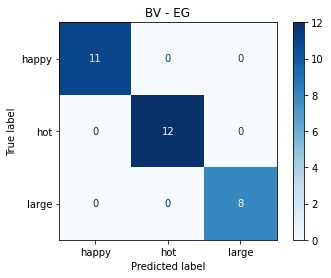

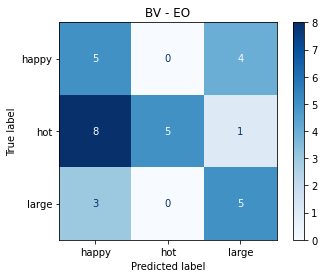

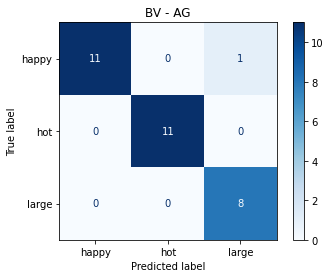

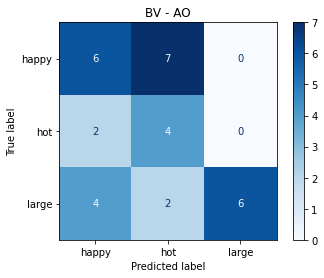

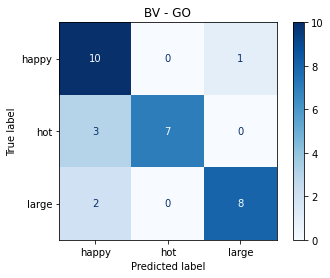

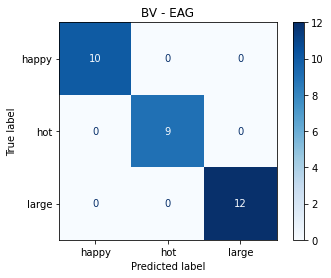

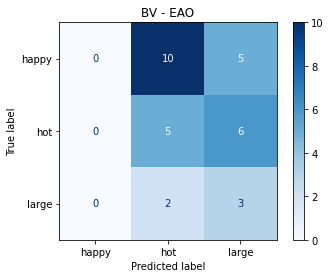

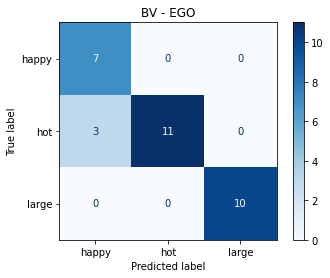

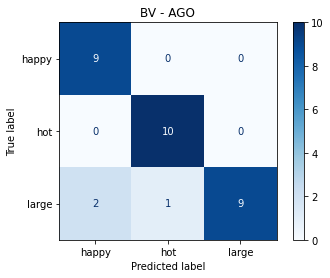

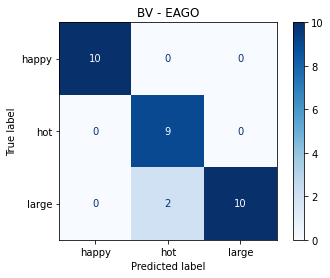

    EMG0L EMG0L     EMG0L      EMG0L  ...     EMG7R     EMG7R     EMG7R    EMG7R
73      0     0  -5.96644    7.93791  ...  -13.2928  -4.74387   28.7825   10.825
53      0     0  -1.19329   0.632951  ...   4.80639   16.1867   13.9168  13.9444
6       0     0  -2.38658    3.65248  ...   2.25801   1.53948     1.651  2.41162
101     0     0  -3.57986   0.705564  ...   1.95124  0.505688   2.12429  1.90149
16      0     0         0  -0.596644  ...   7.70558  -4.33944 -0.362672   6.2138
..    ...   ...       ...        ...  ...       ...       ...       ...      ...
5       0     0   5.96644   0.415112  ...  -1.36867  -6.58564  -7.38346 -4.69924
23      0     0  0.596644    1.17514  ...   1.64185   1.72236   11.2909  3.68629
66      0     0 -0.596644  0.0181533  ...  -1.17768   -3.1883  -3.22498 -1.22384
30      0     0         0          0  ...  -3.37035  -0.52177 -0.181492 -3.87036
87      0     0   3.57986    1.68101  ...  0.865037   3.94515   2.47009  4.58966

[71 rows x 800 columns]
[[ 

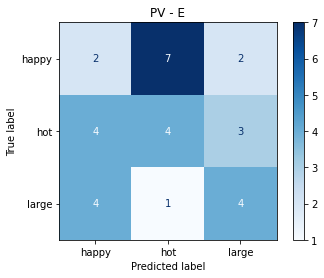

          AXL        AXL        AXL  ...       AZR       AZR       AZR
34  -0.552734  -0.534668  -0.541992  ...  0.859375  0.865234  0.866699
78  -0.545898  -0.504395  -0.186035  ...  0.740723  0.814941  0.841309
56 -0.0673828    -0.0625 -0.0571289  ...  0.836426  0.864746  0.904785
1  -0.0288086  0.0327148    0.17041  ...  0.756836  0.745117  0.769531
21  0.0771484  0.0776367  0.0722656  ...  0.710449  0.756836  0.824219
..        ...        ...        ...  ...       ...       ...       ...
72   0.369629   0.577148   0.238281  ...  0.332031  0.918457    1.1377
55 -0.0595703 -0.0576172    -0.0625  ...  0.895996  0.898926  0.949707
75   0.538086   0.523926   0.255859  ...   1.15576   1.18115   1.20166
94  -0.206055  -0.206055  -0.391602  ...   0.94873  0.925293  0.937012
61   -0.19873  -0.200195  -0.180176  ...  0.650391  0.772949  0.816895

[71 rows x 300 columns]
[[-0.0461548  -0.56606678 -0.33152226 -0.35216392  0.01137509]
 [-0.05511668 -0.54354838 -0.33704834 -0.36732083  0.0097581

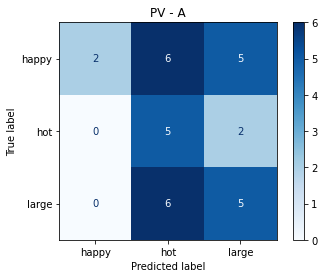

        GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
22   -0.125  -10.375      -38  -44.875  ...  -75.125 -76.6875    -71.5 -71.6875
38  -0.9375        0  -2.5625    -0.25  ...     5.75  -9.3125     -4.5   0.6875
21   33.125    7.375     -5.5 -12.4375  ...   -66.75 -67.8125 -69.9375 -75.3125
65    6.375   0.5625   0.9375    6.125  ...   -8.875   4.5625     -3.5  -1.3125
25   43.125 -158.438  94.8125    126.5  ...      115  161.625    58.25  72.0625
..      ...      ...      ...      ...  ...      ...      ...      ...      ...
20 -26.6875  -5.1875  14.9375  15.6875  ... -76.3125  -67.125 -56.1875   -54.75
18  16.1875  -3.5625   -7.875     -2.5  ...  38.9375  18.1875   14.375   1.8125
64   -1.375     1.75    4.125   3.3125  ...  -2.3125    -2.25   0.3125  -1.4375
48 -14.5625    -5.75  -1.0625   -5.375  ...  -0.4375      0.5     0.25    -0.25
77   4.1875      0.5  23.8125  89.6875  ...  -5.5625  27.1875  18.5625   15.375

[71 rows x 300 columns]
[[ -0.47217046 

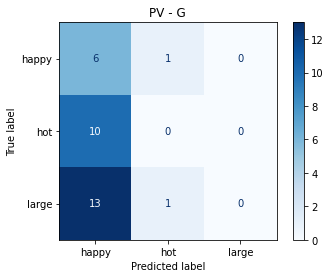

   ORL ORL ORL ORL ORL ORL ORL ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR  OYR
51  73  73  73  73  73  73  73  73  ...   71   71   70   70   69   68   66   64
30  77  75  73  72  69  69  70  72  ...   41   41   41   40   40   38   37   36
66  67  68  67  67  67  68  68  68  ...  172  172  172  173  172  172  172  173
50  73  73  73  73  73  73  73  73  ...   71   71   71   71   70   70   69   69
5   87  88  87  87  87  87  87  87  ...   16   16   15   15   15   15   15   15
..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...
71  85  85  84  84  84  86  88  91  ...  142  141  140  140  140  139  139  139
11  89  88  86  85  85  85  85  85  ...   77   77   77   77   77   77   77   77
83  75  75  73  73  71  69  69  69  ...   42   43   44   46   48   48   49   49
38  80  80  80  80  80  80  80  80  ...   15   14   14   15   15   15   14   14
59  74  74  75  75  75  75  75  74  ...   84   83   82   82   82   82   82   82

[71 rows x 300 columns]
[[ 40.87802238 

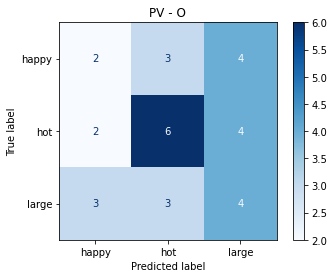

   EMG0L EMG0L     EMG0L      EMG0L  ...       AZR       AZR       AZR       AZR
84     0     0  -2.38658   -1.71732  ...  0.871582  0.905273  0.974609  0.965332
4      0     0  -2.38658   -1.12068  ...  0.830078  0.834473  0.866699  0.837891
67     0     0  -2.38658    2.45919  ...  0.673828  0.878418  0.952148  0.898926
7      0     0  -1.78993  0.0544598  ...  0.854004  0.884766  0.900391  0.898926
28     0     0  -1.78993    1.84439  ...  0.956543  0.991699  0.985352   1.01025
..   ...   ...       ...        ...  ...       ...       ...       ...       ...
38     0     0  0.596644    1.17514  ...  0.922852   1.00928  0.998535   0.96582
33     0     0   1.78993   -1.84439  ...  0.878906  0.890137  0.905273  0.913086
53     0     0  -1.19329   0.632951  ...  0.824219  0.850098  0.844238  0.891602
59     0     0 -0.596644  0.0181533  ...  0.603516  0.583984   0.79834  0.828125
13     0     0   1.78993    19.6348  ...  0.947754  0.992676   1.01953   1.01807

[71 rows x 1100 columns]
[[

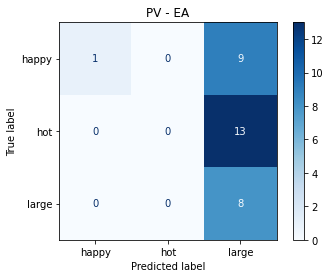

    EMG0L    EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR      GZR
10      0  1.19329  -3.61617  0.678509  ...     0.25   0.4375  -0.3125    -0.75
12      0        0   4.17651  -7.88345  ...    0.125   -0.125   0.5625   0.3125
41      0        0 -0.596644   1.21144  ...    2.875    3.125   0.6875    1.625
65      0        0   1.78993  -2.44104  ...   -8.875   4.5625     -3.5  -1.3125
73      0        0  -5.96644   7.93791  ...  211.125  157.125  154.375    93.75
..    ...      ...       ...       ...  ...      ...      ...      ...      ...
89      0        0    5.3698  -7.32311  ...  92.9375  96.0625  76.1875   64.125
101     0        0  -3.57986  0.705564  ...    27.25  38.4375  29.8125   0.4375
14      0        0  -39.3785   47.7364  ...   1.1875        0   1.6875   0.5625
92      0        0   5.96644  -7.93791  ... -44.0625      -35 -14.8125  -15.625
6       0        0  -2.38658   3.65248  ...    9.875    3.375   3.8125  10.3125

[71 rows x 1100 columns]
[[-23.5125121 

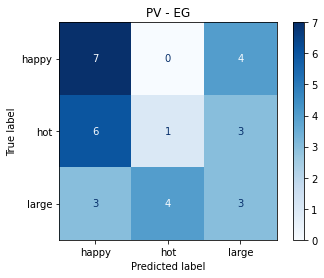

   EMG0L    EMG0L    EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
17     0        0        0  -0.596644  -1.17514  ...   66   65   65   65   65
58     0        0        0          0  -1.19329  ...   83   83   83   83   83
68     0        0 -7.15973   0.814483   10.2871  ...  143  143  144  143  143
96     0        0 -1.78993    1.84439  -1.50549  ...  172  172  172  171  171
77     0        0 -17.3027    20.8123   3.05662  ...  125  126  127  128  128
..   ...      ...      ...        ...       ...  ...  ...  ...  ...  ...  ...
37     0 -2.38658  1.86255    3.57951  -3.00842  ...   15   15   15   15   15
19     0        0        0  -0.596644 -0.578491  ...  163  160  159  157  156
7      0        0 -1.78993  0.0544598  -5.62754  ...   12   11   10   10    9
16     0        0        0  -0.596644 -0.578491  ...   69   69   69   69   69
2      0        0 -2.38658    7.23234  -10.9033  ...  135  135  133  132  131

[71 rows x 1100 columns]
[[ 39.63375213 -39.80690106   3.659739

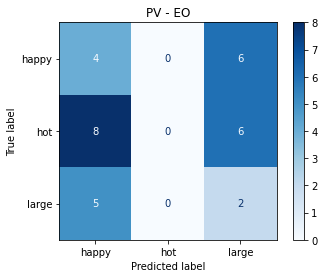

          AXL        AXL         AXL  ...      GZR      GZR      GZR
8   -0.418457  -0.438477    -1.37256  ...    21.25  11.3125   6.3125
93  -0.241699  -0.210449   -0.201172  ... -75.4375 -52.0625      -15
66  -0.543457  -0.534668   -0.536621  ...      -24 -23.0625  18.0625
68  -0.461426   -0.45459   -0.445801  ...     5.25  -9.4375    -13.5
14  -0.891602  -0.507324   0.0673828  ...        0   1.6875   0.5625
..        ...        ...         ...  ...      ...      ...      ...
25   -0.73584 -0.0708008    0.192383  ...  161.625    58.25  72.0625
61   -0.19873  -0.200195   -0.180176  ...    -10.5  -8.4375   -0.125
48 -0.0522461 -0.0375977 -0.00488281  ...      0.5     0.25    -0.25
0   -0.770996   -1.09424   -0.444336  ...  -14.125   -13.25    -13.5
89 -0.0541992   0.205078    0.140625  ...  96.0625  76.1875   64.125

[71 rows x 600 columns]
[[  6.38951628   0.90570099 -24.0624442   -8.00760043  -8.63027697]
 [ -3.48485337  -7.54383048 -12.74045301 -24.04190194 -11.68926168]
 [ 23.85134

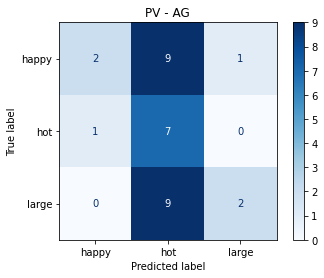

          AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
6    0.828613   0.861816   0.201172  -0.108887  ...   16   16   16   17
46 -0.0688477 -0.0722656 -0.0610352 -0.0751953  ...   29   29   29   29
79   0.258789   0.327637   0.472168   0.513672  ...  159  159  158  158
42  -0.501953  -0.500488   -0.48291  -0.492676  ...  119  119  118  118
40   0.551758   0.541992   0.549316   0.561523  ...   12   12   12   12
..        ...        ...        ...        ...  ...  ...  ...  ...  ...
58  -0.194824  -0.201172  -0.192871  -0.200684  ...   83   83   83   83
54 -0.0664062    -0.0625 -0.0712891 -0.0795898  ...  156  156  155  154
25   -0.73584 -0.0708008   0.192383  0.0166016  ...  106  111  112  112
75   0.538086   0.523926   0.255859   0.200684  ...  174    0    4    6
22 -0.0820312 -0.0644531 -0.0375977  0.0273438  ...  169  167  165  164

[71 rows x 600 columns]
[[ 94.87869939  27.46564362  -3.05017611   8.27642547]
 [ 94.64550074  23.9047627   -2.67581215   4.39187837]
 

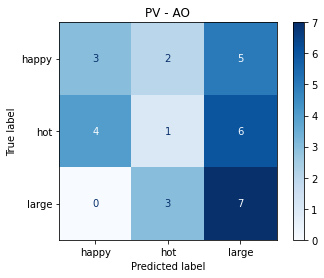

         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
100  44.0625    27.75  109.688      115  144.875  ...  164  165  166  168  169
57   -0.1875    0.875   0.1875    -0.25   -2.375  ...   84   84   84   84   84
44     1.375    5.125   0.6875  -6.6875   5.8125  ...  123  122  122  122  122
0      148.5  204.312   31.125   60.375  59.4375  ...  129  128  128  127  127
72   57.6875  -26.875  -31.875   8.6875    -1.75  ...  147  154  165  171  179
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
20  -26.6875  -5.1875  14.9375  15.6875  -7.4375  ...  168  166  164  163  162
78        79   154.75  21.4375 -16.0625   129.25  ...  124  124  125  126  126
14   15.9375  51.6875 -36.9375   8.3125  -33.125  ...   68   68   68   68   68
98     94.75   62.125  79.3125   107.75  143.062  ...  171  172  173  173  174
12     2.875 -13.5625       -9   -1.375  -0.4375  ...   77   77   77   77   77

[71 rows x 600 columns]
[[ 18.84478102  25.94775102

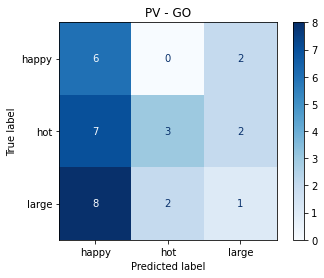

   EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
5      0     0   5.96644   0.415112  ...   -1.125  -0.3125    3.875   2.3125
40     0     0  -1.78993    1.24775  ...     11.5      5.5    0.375  -8.5625
48     0     0   1.19329    2.94691  ...  -0.4375      0.5     0.25    -0.25
43     0     0  0.596644   -1.80809  ...  -1.5625    2.875   0.3125    0.875
67     0     0  -2.38658    2.45919  ...  -59.375 -83.6875 -50.3125 -43.0625
..   ...   ...       ...        ...  ...      ...      ...      ...      ...
81     0     0   1.19329   -6.00275  ...   2.0625   1.6875   -0.625        1
90     0     0  -1.19329    4.21282  ...  109.375  112.125  104.312     89.5
73     0     0  -5.96644    7.93791  ...  211.125  157.125  154.375    93.75
59     0     0 -0.596644  0.0181533  ...   -0.375  -5.4375  -5.8125    1.125
1      0     0  -6.56309    9.14935  ... -16.8125   -22.75   -21.75  -24.875

[71 rows x 1400 columns]
[[-10.12851548  -9.01733674  33.73897933 ...   0.8

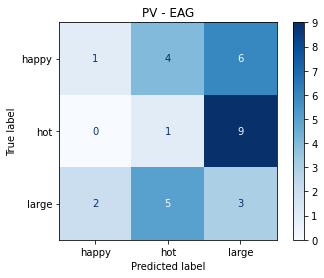

   EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
20     0     0 -0.596644   0.614797 -0.899592  ...  168  166  164  163  162
41     0     0 -0.596644    1.21144  -1.51439  ...  114  114  114  114  114
74     0     0  -7.15973   -49.9003   87.0073  ...    0    5    7    8    9
15     0     0  -1.19329  0.0363065  -1.16623  ...   79   78   74   71   68
84     0     0  -2.38658   -1.71732   6.07501  ...   49   50   50   51   51
..   ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
27     0     0         0   -1.78993   2.44104  ...   35   33   32   31   30
51     0     0  -1.19329    1.82624   1.16588  ...   70   69   68   66   64
56     0     0  -1.19329   0.632951  0.605546  ...  154  155  155  156  156
82     0     0  -9.54631    7.45018   11.9315  ...  156  156  156  156  156
11     0     0  -8.94966    5.04545   12.8855  ...   77   77   77   77   77

[71 rows x 1400 columns]
[[-44.47621886  13.34257927  35.17160846 ...  -5.12616796  -1.

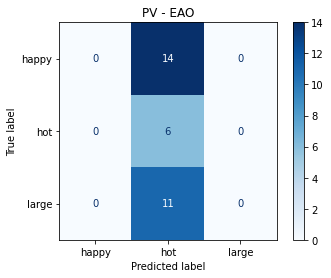

   EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
3      0     0   1.78993   -2.44104  -2.65287  ...  139  138  137  135  134
26     0     0   1.19329    -5.4061  0.136325  ...  115  115  116  116  114
31     0     0    5.3698    -10.903   8.25971  ...  173  173  172  172  172
21     0     0         0   -2.98322   3.07399  ...  170  168  166  164  162
64     0     0 -0.596644  0.0181533  0.311849  ...  173  173  173  173  173
..   ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
89     0     0    5.3698   -7.32311  0.394415  ...  123  125  130  133  135
48     0     0   1.19329    2.94691  -6.08426  ...   69   69   69   69   69
49     0     0   11.9329   -11.1027  -23.8096  ...   69   69   69   69   69
75     0     0  -17.3027    23.7956   11.3189  ...  169  174    0    4    6
12     0     0   4.17651   -7.88345     8.196  ...   77   77   77   77   77

[71 rows x 1400 columns]
[[ -3.46162014  -1.37076695  -0.59606546 ...  -2.86858635  39.

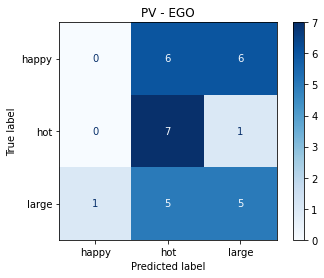

          AXL       AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
63   0.753418  0.755371   0.741699   0.739258  ...    1    0    0  179
71  -0.748535 -0.726562  -0.346191  -0.133789  ...  140  139  139  139
68  -0.461426  -0.45459  -0.445801  -0.459961  ...  143  144  143  143
88   0.265137  0.247559   0.367188   0.396484  ...  122  125  129  132
30   -0.59375 -0.611816  -0.655273  -0.584961  ...   40   38   37   36
..        ...       ...        ...        ...  ...  ...  ...  ...  ...
42  -0.501953 -0.500488   -0.48291  -0.492676  ...  119  119  118  118
69  -0.664062 -0.631836   -0.51416  -0.183594  ...  140  140  140  140
11  -0.170898   0.10791   0.236816   0.172363  ...   77   77   77   77
50  -0.208008 -0.205078  -0.216309  -0.195801  ...   70   70   69   69
19 -0.0976562  -0.09375 -0.0991211 -0.0581055  ...  160  159  157  156

[71 rows x 900 columns]
[[  -2.14827472   -1.18032097    6.69694691 ...   12.41875578
     5.56774899  -36.77062136]
 [  -2.78849613   -1.10654533 

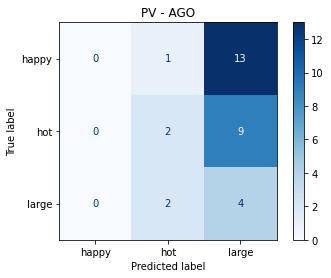

    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
55      0     0  -1.19329  0.0363065   1.22034  ...  156  157  157  157  157
29      0     0         0   -1.19329   1.22959  ...   41   41   41   41   41
98      0     0   6.56309   -6.16613  -7.42532  ...  171  172  173  173  174
4       0     0  -2.38658   -1.12068   1.88035  ...   19   19   19   19   19
100     0     0  -7.15973    4.99099   12.5466  ...  164  165  166  168  169
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
89      0     0    5.3698   -7.32311  0.394415  ...  123  125  130  133  135
69      0     0   4.17651   -9.07673   1.07257  ...  140  140  140  140  140
91      0     0         0    2.98322  -5.46056  ...   77   77   77   77   76
50      0     0 -0.596644    1.80809  -2.72583  ...   71   70   70   69   69
5       0     0   5.96644   0.415112  -12.0863  ...   15   15   15   15   15

[71 rows x 1700 columns]
[[-2.45946171e+00  1.83316146e-01  4.49815463e+00 

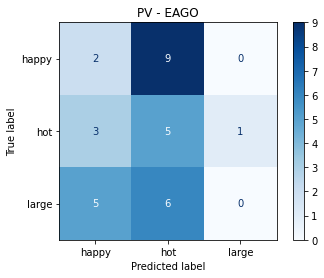

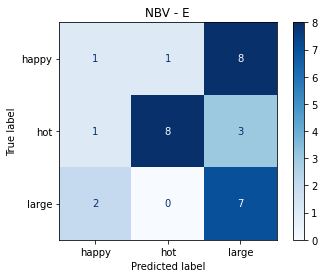

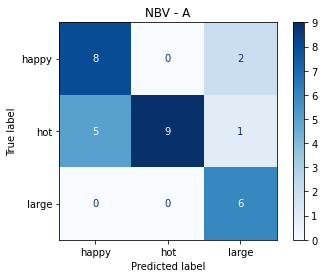

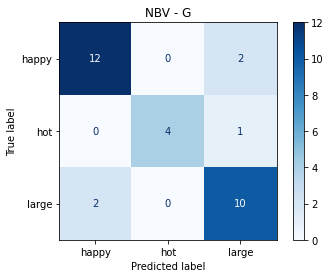

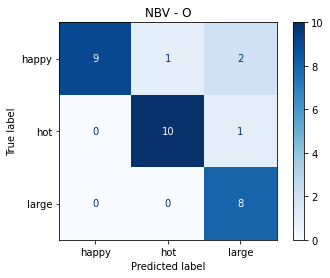

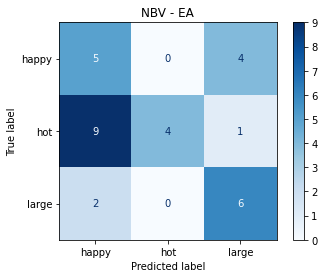

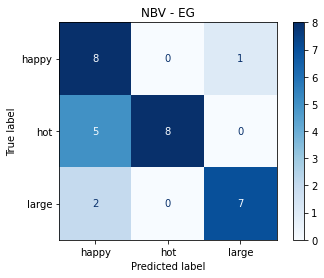

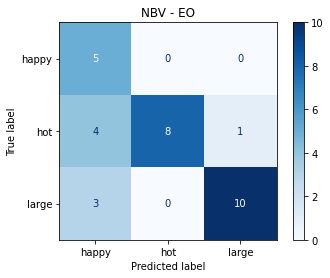

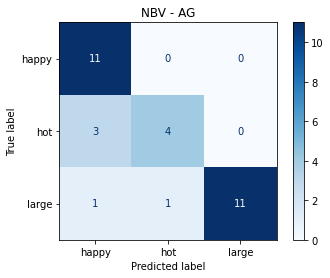

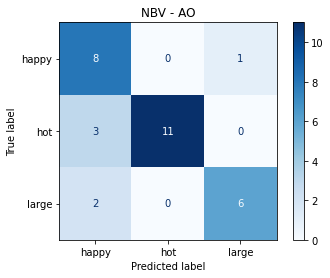

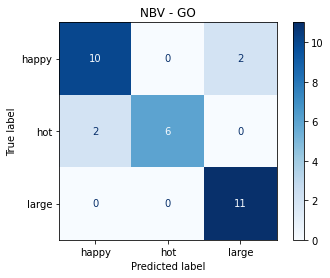

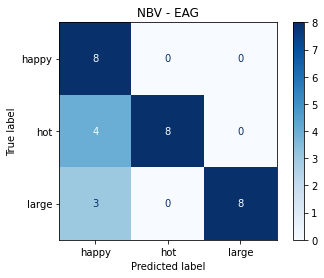

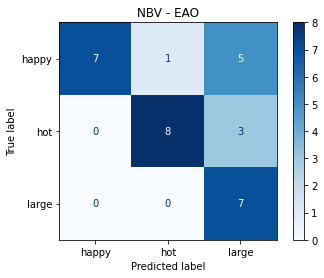

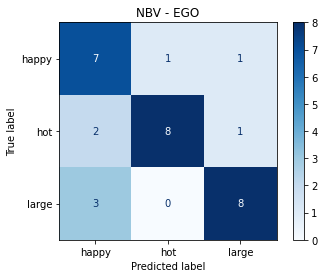

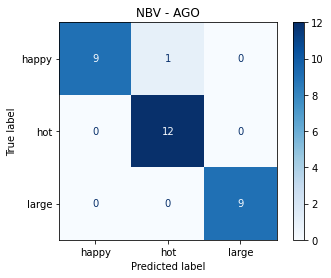

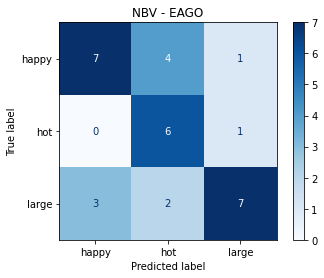

       EMG0L       EMG0L     EMG0L  ...       EMG7R       EMG7R       EMG7R
91  0.350476  -0.0106635 -0.183184  ...    0.177913  -0.0065531  -0.0476856
63   0.18571 -0.00565035 -0.104968  ...  -0.0184072    0.020243  -0.0368837
93  0.266501 -0.00810845 -0.147248  ...  -0.0167491  -0.0109057  -0.0363463
4   0.295954 -0.00900459 -0.164158  ...  0.00366396   0.0146962  0.00865422
62  0.307454 -0.00935448 -0.160698  ...  0.00297131 -0.00349117  -0.0319173
..       ...         ...       ...  ...         ...         ...         ...
6   0.298322 -0.00907663 -0.165321  ...  0.00606095  0.00650002  0.00949456
67  0.329988  -0.0100401 -0.185808  ...   0.0133885 -0.00435444  -0.0252819
59  0.360238  -0.0109605 -0.191101  ...   0.0224416  -0.0268818   0.0700259
89  0.285063 -0.00867322 -0.119163  ...   0.0885124   -0.116146 -0.00813292
56  0.360933  -0.0109816 -0.196016  ...  -0.0127863 -0.00553631  0.00321051

[71 rows x 800 columns]
[[-0.01181165 -0.22609627 -0.03085717 ...  0.00707422 -0.007857

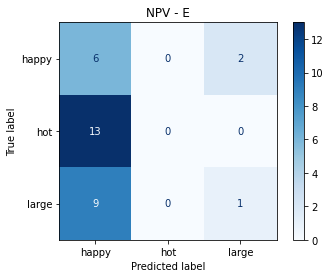

          AXL        AXL        AXL  ...       AZR       AZR       AZR
19   0.452983   0.454528   0.452404  ...   0.83298  0.822747   0.84109
7        0.75    0.70452   0.708379  ...  0.870728  0.879548  0.878721
82   0.310032   0.313658   0.474617  ...  0.738113  0.741538  0.736099
2   0.0748665  0.0845892          0  ...  0.816723  0.773213  0.809188
91   0.436371   0.401982   0.541093  ...  0.779484  0.875851     0.864
..        ...        ...        ...  ...       ...       ...       ...
57   0.355788   0.358019   0.353112  ...  0.697523  0.775373  0.824001
99   0.467245   0.505219   0.575839  ...  0.832335  0.824118  0.838997
72   0.636031   0.732952   0.574685  ...  0.618471  0.892359  0.994755
65   0.093274   0.100465  0.0856599  ...  0.679991  0.647207  0.662224
84   0.360693   0.357889   0.448381  ...  0.926586  0.962783   0.95794

[71 rows x 300 columns]
[[ 0.03559652 -0.01970116  0.17143697 -0.02265764 -0.06693579]
 [ 0.0370103  -0.02001766  0.17311718 -0.02205574 -0.0683666

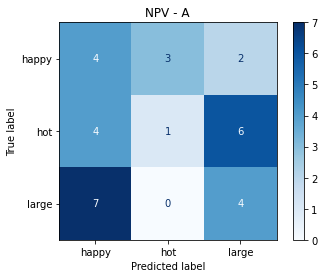

         GXL       GXL       GXL  ...       GZR       GZR       GZR
94  0.491478  0.491478  0.270228  ...  0.495931  0.494856  0.497312
13  0.499999  0.447048   0.38295  ...  0.463441  0.465081  0.465572
80  0.524549  0.582141  0.520612  ...  0.579655  0.588356  0.585041
88  0.695007  0.696716  0.811918  ...  0.926171  0.888592  0.871891
23  0.459062  0.458726  0.450672  ...  0.487753  0.327686  0.317954
..       ...       ...       ...  ...       ...       ...       ...
43  0.394875  0.390879   0.38275  ...  0.392946  0.387297  0.388537
90  0.715853  0.704881  0.826523  ...  0.863413  0.839764   0.79493
42  0.390683  0.391228  0.383736  ...  0.243428   0.36303  0.382782
15  0.614029  0.614893  0.615757  ...  0.281789  0.517795  0.645128
20  0.371792  0.436223  0.496534  ...  0.250608  0.283386  0.287694

[71 rows x 300 columns]
[[ 0.00523273  0.00656906  0.00029811  0.00787913  0.01210945]
 [ 0.006271    0.0067696   0.00053502  0.00802014  0.0134004 ]
 [ 0.00320974 -0.00566846 -0.0418

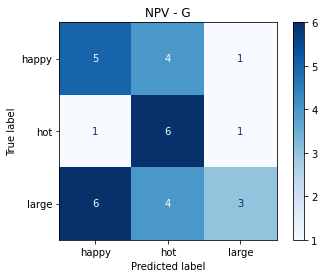

         ORL       ORL       ORL  ...       OYR       OYR        OYR
96  0.536313  0.541899  0.553073  ...  0.960894  0.955307   0.955307
15  0.553846  0.553846  0.553846  ...       0.6  0.553846   0.507692
6   0.636364  0.643939  0.659091  ...  0.106061  0.106061   0.113636
78  0.320755  0.339623   0.40566  ...  0.820755  0.830189   0.830189
31  0.231884   0.23913  0.253623  ...  0.971014  0.971014   0.971014
..       ...       ...       ...  ...       ...       ...        ...
13  0.698413  0.698413  0.698413  ...  0.365079  0.365079   0.349206
11  0.725806  0.709677  0.677419  ...  0.532258  0.532258   0.532258
73    0.4375  0.431818  0.431818  ...  0.994318         0  0.0227273
63  0.530726  0.530726  0.530726  ...         0         0          1
87     0.125     0.125     0.125  ...  0.541667      0.55      0.575

[71 rows x 300 columns]
[[-0.28269261  0.05094076  0.00409919 -0.45851256]
 [-0.28135795  0.05065094  0.00459634 -0.45870514]
 [-0.27265976  0.01712385  0.01471469 -0.4382

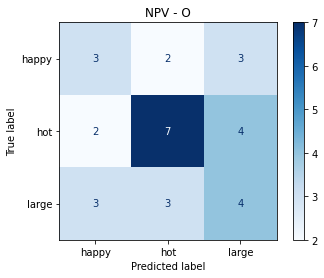

       EMG0L       EMG0L      EMG0L  ...       AZR       AZR       AZR
23  0.279404 -0.00850104  -0.143126  ...  0.716834  0.703515  0.676744
27  0.333668  -0.0101521  -0.174399  ...  0.844486  0.828664  0.811485
25  0.274134 -0.00834068  -0.132532  ...  0.965074  0.962341  0.751805
91  0.350476  -0.0106635  -0.183184  ...  0.779484  0.875851     0.864
73  0.299492 -0.00911222  -0.179934  ...  0.766735    0.6694  0.716762
..       ...         ...        ...  ...       ...       ...       ...
31  0.313565  -0.0095404  -0.124696  ...  0.823758  0.812809  0.768594
49  0.341557  -0.0103921 -0.0920523  ...  0.640831  0.640238  0.640437
17  0.260696 -0.00793183  -0.136259  ...  0.736093  0.739997  0.733946
67  0.329988  -0.0100401  -0.185808  ...  0.888414  0.928723  0.899626
35  0.275049 -0.00836852  -0.147992  ...  0.876973  0.843779  0.806175

[71 rows x 1100 columns]
[[ 0.08989755  0.02590232  0.15691653 ... -0.07558197 -0.02098962
  -0.08472087]
 [ 0.07853444  0.04639683  0.15271209 ...

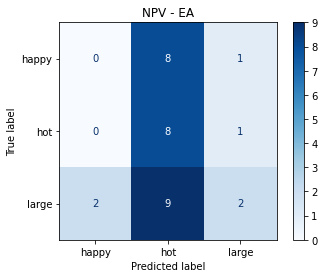

        EMG0L       EMG0L      EMG0L  ...       GZR       GZR       GZR
54   0.317364 -0.00965599   -0.17434  ...    0.4195  0.326518  0.288184
53   0.284762 -0.00866405  -0.154261  ...  0.428707  0.441722   0.40421
14   0.265579 -0.00808041  -0.378924  ...  0.449563  0.453928  0.451018
3    0.259716 -0.00790201  -0.125217  ...  0.396769  0.381212   0.43196
95   0.245985 -0.00748424  -0.123336  ...   0.60901   0.56807  0.552121
..        ...         ...        ...  ...       ...       ...       ...
56   0.360933  -0.0109816  -0.196016  ...  0.557817   0.60654  0.592681
5    0.283529 -0.00862655  -0.123538  ...  0.473731  0.485827  0.481314
45   0.178004 -0.00541589 -0.0172213  ...  0.605976  0.599358  0.600303
100  0.235248 -0.00715757   -0.16387  ...  0.417478  0.426921   0.46709
73   0.299492 -0.00911222  -0.179934  ...  0.710931  0.706058  0.598626

[71 rows x 1100 columns]
[[-0.08190744  0.01373361  0.0195803  ... -0.03462703 -0.0102156
   0.02407671]
 [-0.07779676  0.03941805  0.0

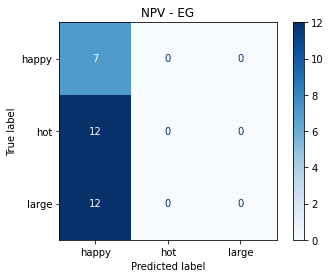

       EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
49  0.341557  -0.0103921 -0.0920523  ...   0.391304   0.391304   0.391304
45  0.178004 -0.00541589 -0.0172213  ...          0          0          0
11  0.258368 -0.00786101  -0.174996  ...   0.532258   0.532258   0.532258
4   0.295954 -0.00900459  -0.164158  ...  0.0512821  0.0512821  0.0512821
53  0.284762 -0.00866405  -0.154261  ...   0.387097   0.370968    0.33871
..       ...         ...        ...  ...        ...        ...        ...
44  0.302775  -0.0092121  -0.162704  ...   0.708661   0.708661   0.708661
92  0.279509 -0.00850423 -0.0923399  ...   0.505882   0.505882   0.505882
41  0.404337  -0.0123022  -0.216267  ...   0.677966   0.677966   0.677966
13  0.270673 -0.00823538  -0.132742  ...   0.365079   0.365079   0.349206
59  0.360238  -0.0109605  -0.191101  ...   0.415584   0.415584   0.415584

[71 rows x 1100 columns]
[[ 0.65661101  0.05523534  0.4180166  ... -0.22148781 -0.04143962
  -0.26106859]
 [ 0.

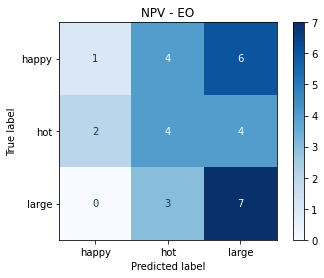

           AXL        AXL        AXL  ...       GZR       GZR       GZR
81    0.249638   0.317684   0.477767  ...   0.60134  0.594813  0.599399
43   0.0354796  0.0349543  0.0394217  ...  0.392946  0.387297  0.388537
0     0.126699          0   0.254737  ...  0.420369  0.422054  0.421573
100  0.0879118  0.0814082   0.257232  ...  0.417478  0.426921   0.46709
32    0.703061   0.724304   0.721106  ...   0.50663  0.504655  0.505219
..         ...        ...        ...  ...       ...       ...       ...
9     0.197597   0.192702   0.145528  ...    0.4453  0.475457  0.472409
1     0.308269   0.340827   0.413695  ...  0.430943  0.433472   0.42557
70    0.156598   0.149712   0.119059  ...  0.464592  0.464864  0.459427
60    0.315803   0.316805   0.329577  ...  0.433494   0.41847   0.43984
29    0.135257   0.139073   0.131441  ...  0.574631  0.613538  0.601099

[71 rows x 600 columns]
[[-0.2847897  -0.08137105 -0.18431135 ...  0.01929664  0.14012775
  -0.04754507]
 [-0.28780568 -0.05368764 -0.2

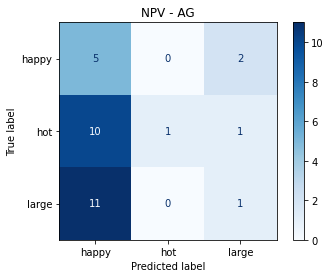

           AXL       AXL       AXL  ...       OYR        OYR        OYR
51    0.292143  0.288584  0.291126  ...  0.461538   0.430769        0.4
85    0.389861  0.500796  0.448056  ...  0.246154   0.230769   0.230769
76    0.301627  0.323235  0.467811  ...  0.794643   0.794643   0.803571
78   0.0895035  0.108013      0.25  ...  0.820755   0.830189   0.830189
58    0.315091  0.311569  0.316175  ...  0.428571   0.428571   0.428571
..         ...       ...       ...  ...       ...        ...        ...
75    0.697866  0.691419  0.569364  ...         0  0.0225989  0.0338983
94    0.409418  0.409418  0.335474  ...  0.505618   0.505618   0.505618
61    0.351146   0.35039  0.360725  ...       0.4        0.4        0.4
26      0.3646  0.352475  0.300774  ...         1          1    0.97561
101   0.289939  0.309734  0.426409  ...  0.964286   0.964286   0.964286

[71 rows x 600 columns]
[[ 0.6506704  -0.43603147  0.01606828 -0.1623921  -0.07019087 -0.01572021]
 [ 0.65102779 -0.43708493  0.0171193

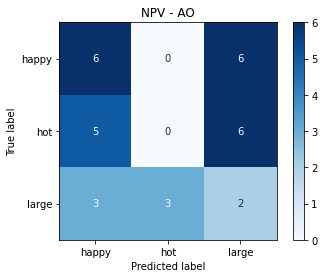

         GXL       GXL       GXL  ...        OYR        OYR        OYR
85  0.418522  0.262757  0.358059  ...   0.246154   0.230769   0.230769
55  0.447952  0.443878  0.443674  ...   0.882022   0.882022   0.882022
40  0.567555  0.569899  0.571405  ...      0.016      0.016      0.016
37  0.422904  0.441621   0.42439  ...  0.0162602  0.0162602  0.0162602
89  0.628758  0.567005   0.64886  ...    0.68254   0.706349   0.722222
..       ...       ...       ...  ...        ...        ...        ...
2   0.505768  0.556594  0.915291  ...   0.778846   0.769231   0.759615
95  0.359914  0.288556   0.10424  ...    0.96648    0.96648   0.960894
91  0.503633  0.754358  0.649417  ...   0.533333   0.533333   0.522222
26   0.45608   0.42301  0.370651  ...          1          1    0.97561
29  0.654325  0.654903  0.647093  ...   0.144144   0.144144   0.144144

[71 rows x 600 columns]
[[ 5.40126950e-01 -4.09476775e-01  3.11789985e-02 ... -5.26914115e-02
   4.25669377e-02 -1.33707637e-01]
 [ 5.20313762e-01 

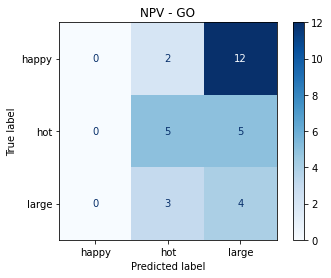

       EMG0L       EMG0L     EMG0L  ...       GZR       GZR       GZR
4   0.295954 -0.00900459 -0.164158  ...  0.453583  0.454735  0.460033
95  0.245985 -0.00748424 -0.123336  ...   0.60901   0.56807  0.552121
40  0.314233 -0.00956071 -0.176174  ...  0.585301  0.571573  0.547632
12  0.329435  -0.0100233 -0.146564  ...  0.475674  0.477452  0.476806
25  0.274134 -0.00834068 -0.132532  ...         1  0.682655  0.725058
..       ...         ...       ...  ...       ...       ...       ...
60  0.268189  -0.0081598 -0.143188  ...  0.433494   0.41847   0.43984
46  0.352349  -0.0107204 -0.146579  ...  0.449691  0.452302  0.434029
8   0.342899  -0.0104329  -0.19294  ...  0.629171  0.600183  0.585598
51  0.254407 -0.00774047 -0.139029  ...  0.458475  0.445806  0.432334
43  0.376523  -0.0114559 -0.191005  ...  0.392946  0.387297  0.388537

[71 rows x 1400 columns]
[[-0.22158404 -0.00273652  0.00264122 ...  0.16610646  0.04761735
  -0.03186567]
 [-0.20808564 -0.09606036  0.15756315 ... -0.02341236

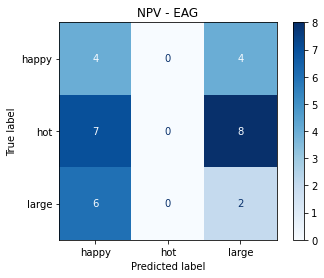

       EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
14  0.265579 -0.00808041  -0.378924  ...  0.378788  0.378788  0.378788
79  0.288573 -0.00878001  0.0246545  ...  0.913295  0.907514  0.907514
66  0.235042 -0.00715128  -0.125863  ...  0.966292  0.966292   0.97191
12  0.329435  -0.0100233  -0.146564  ...  0.491228  0.491228  0.491228
57  0.372374  -0.0113297  -0.198861  ...  0.426667  0.426667  0.426667
..       ...         ...        ...  ...       ...       ...       ...
32  0.198881 -0.00605109 -0.0949097  ...  0.978102  0.978102  0.978102
87   0.29404 -0.00894634  -0.136558  ...  0.541667      0.55     0.575
78  0.338481  -0.0102985  -0.205599  ...  0.820755  0.830189  0.830189
69  0.346886  -0.0105542  -0.148932  ...  0.770492  0.770492  0.770492
17  0.260696 -0.00793183  -0.136259  ...  0.424658  0.424658  0.424658

[71 rows x 1400 columns]
[[ 0.87385274 -0.20069805 -0.13445573 ... -0.14363925  0.12020563
  -0.14445104]
 [ 0.84832985 -0.18255226  0.01387796 ...

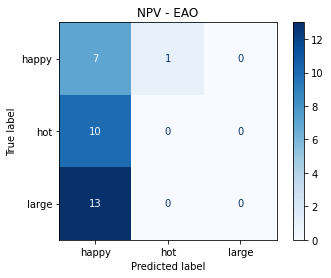

       EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
85  0.279381 -0.00850033  -0.131819  ...   0.246154   0.230769   0.230769
12  0.329435  -0.0100233  -0.146564  ...   0.491228   0.491228   0.491228
95  0.245985 -0.00748424  -0.123336  ...    0.96648    0.96648   0.960894
4   0.295954 -0.00900459  -0.164158  ...  0.0512821  0.0512821  0.0512821
73  0.299492 -0.00911222  -0.179934  ...   0.994318          0  0.0227273
..       ...         ...        ...  ...        ...        ...        ...
9   0.306777 -0.00933386   -0.16759  ...       0.75       0.75       0.75
97  0.292585 -0.00890208  -0.147189  ...   0.955307   0.949721   0.944134
45  0.178004 -0.00541589 -0.0172213  ...          0          0          0
56  0.360933  -0.0109816  -0.196016  ...   0.865922   0.871508   0.871508
90  0.320884  -0.0097631  -0.172731  ...      0.675   0.691667      0.725

[71 rows x 1400 columns]
[[ 0.56121157 -0.3965865   0.0417769  ... -0.18458116 -0.03780899
  -0.06344699]
 [ 0.

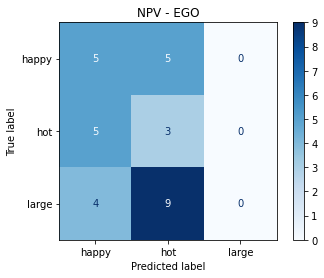

           AXL        AXL       AXL  ...        OYR        OYR         OYR
100  0.0879118  0.0814082  0.257232  ...   0.907143   0.921429    0.928571
7         0.75    0.70452  0.708379  ...  0.0178571  0.0178571  0.00892857
36    0.141005    0.14332  0.141237  ...   0.632812   0.632812    0.632812
37    0.581255   0.590883  0.561801  ...  0.0162602  0.0162602   0.0162602
22    0.458028   0.464444  0.474247  ...   0.914729   0.899225    0.891473
..         ...        ...       ...  ...        ...        ...         ...
46    0.318702    0.31684  0.322958  ...  0.0136986  0.0136986   0.0136986
55    0.400262   0.401309  0.398691  ...   0.882022   0.882022    0.882022
60    0.315803   0.316805  0.329577  ...     0.4125     0.4125      0.4125
86    0.300901   0.301962  0.288706  ...   0.169231   0.184615         0.2
89    0.461322   0.576058  0.547536  ...    0.68254   0.706349    0.722222

[71 rows x 900 columns]
[[-0.19987627 -0.50789137  0.12615618 ... -0.0158034  -0.07050912
  -0.1293

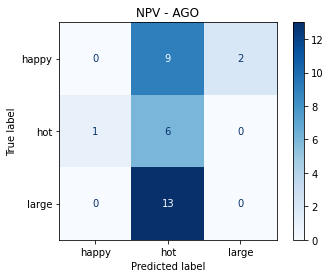

       EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
3   0.259716 -0.00790201  -0.125217  ...  0.814815  0.796296  0.787037
72  0.308521 -0.00938694  -0.181654  ...  0.921348  0.955056         1
21  0.359986  -0.0109528  -0.188155  ...  0.906977  0.891473  0.875969
70  0.312724 -0.00951481  -0.146993  ...  0.755556  0.755556  0.755556
92  0.279509 -0.00850423 -0.0923399  ...  0.505882  0.505882  0.505882
..       ...         ...        ...  ...       ...       ...       ...
24  0.336005  -0.0102231  -0.178761  ...  0.873418  0.962025         1
22  0.281664 -0.00856981  -0.147218  ...  0.914729  0.899225  0.891473
81  0.295534  -0.0089918  -0.148891  ...  0.918605  0.918605  0.918605
93  0.266501 -0.00810845  -0.147248  ...  0.546392  0.546392  0.546392
47  0.258123 -0.00785354  -0.109524  ...  0.380952  0.380952  0.380952

[71 rows x 1700 columns]
[[-0.47241752 -0.02309422 -0.33652165 ... -0.04826885  0.11553064
   0.10349859]
 [-0.46940796 -0.01934806 -0.34243688 ...

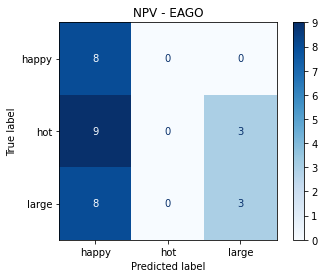

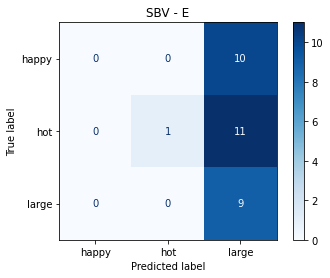

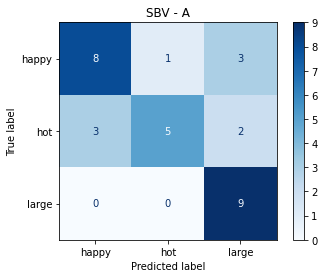

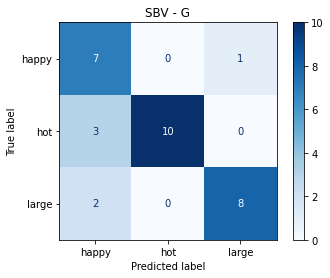

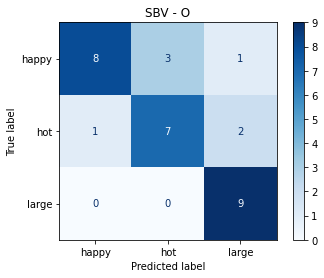

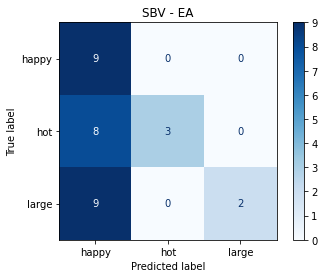

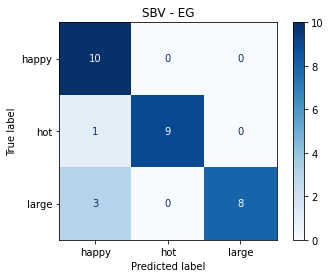

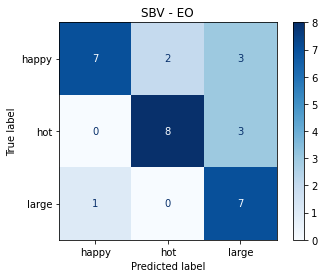

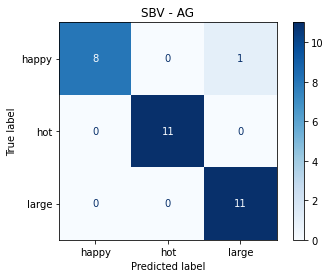

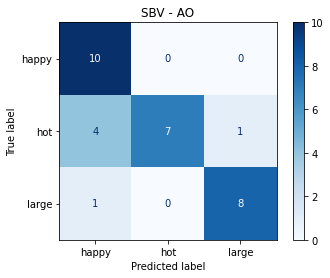

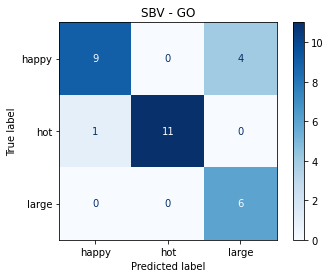

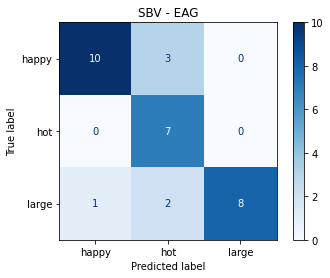

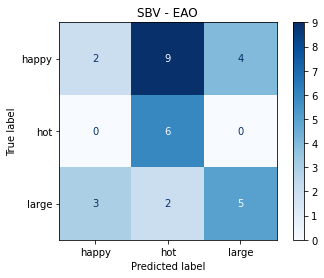

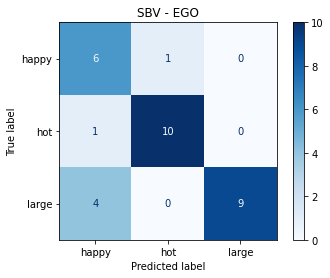

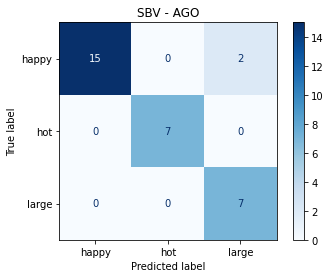

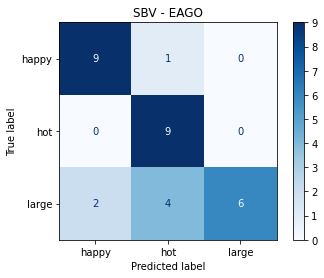

        EMG0L        EMG0L      EMG0L  ...     EMG7R      EMG7R      EMG7R
98  0.0392444  -0.00119403   0.557965  ...  0.147822  -0.143207 -0.0873818
21  0.0736189   -0.0022399 -0.0384786  ... -0.101716   0.672863  0.0973598
34  0.0470523   -0.0014316  -0.172498  ... -0.336927   0.469196    0.42627
10  0.0183708    0.0797506  -0.252974  ... -0.832819  -0.119725   0.230556
7   0.0256089 -0.000779167 -0.0904044  ...  0.198413  -0.120179 -0.0719139
..        ...          ...        ...  ...       ...        ...        ...
58  0.0224405 -0.000682767 -0.0117291  ...  0.657126 -0.0455517  -0.189946
73  0.0406878  -0.00123795  -0.262917  ... -0.192134    1.16574   0.438431
96  0.0442954  -0.00134771  -0.224114  ...  -0.70901  -0.628246   -0.84967
87  0.0197413 -0.000600642   0.210564  ...   0.24342   0.152407   0.283187
40  0.0697413  -0.00212192  -0.199908  ...  0.166523   0.206441   0.086106

[71 rows x 800 columns]
[[ 1.37643178 -1.14902163 -0.6940322  ... -0.72540041 -0.37328498
  -0.2146

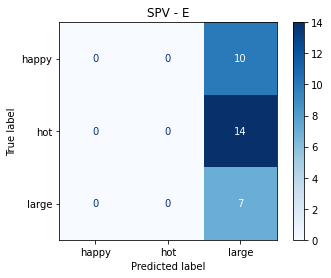

         AXL        AXL        AXL  ...       AZR       AZR       AZR
37  0.435271   0.482433   0.339984  ...   1.28323   1.21681    1.3044
38  0.405084   0.448695   0.428343  ...    1.3771   1.35577   1.29084
14  -2.28983   -1.56024  -0.469099  ...   1.31547   1.30807   1.28581
98   -1.9317   -2.01502   -1.18893  ...   1.92193   2.24986  0.310951
99  -0.48694  -0.334788 -0.0518391  ...  0.975855  0.942934   1.00255
..       ...        ...        ...  ...       ...       ...       ...
41  -1.15618   -1.15703   -1.12822  ...   1.14169   1.16626    1.1688
25  -1.87509  -0.675067  -0.200168  ...   2.11353   2.10119   1.15052
60  -0.72502  -0.721518  -0.676872  ...  0.670405  0.980306   1.20179
69  -1.68135   -1.62231   -1.40674  ...   1.00928  0.969919  0.975286
20 -0.341904 -0.0949827  -0.161293  ...   1.09164   1.16755   1.16231

[71 rows x 300 columns]
[[-0.8386789   0.63630219 -0.00164564  0.34075955  0.16500741]
 [-0.81564093  0.70889663  0.00741339  0.28859244  0.19868166]
 [-0.7550

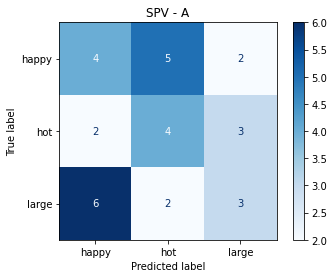

           GXL         GXL        GXL  ...         GZR         GZR        GZR
25    0.626337    -2.47737    1.42223  ...     2.45102    0.859235    1.07192
16  0.00417983  0.00889365  -0.566192  ...   0.0583887    0.204517   0.231621
54    0.016263  -0.0288541 -0.0739712  ...   -0.347785    -1.08366   -1.38703
35  -0.0278304   0.0413936  0.0824587  ...   -0.667272   -0.446694  -0.140466
77   0.0419018 -0.00551578    0.29426  ...    0.337659     0.22675   0.185762
..         ...         ...        ...  ...         ...         ...        ...
43   0.0196023  -0.0116893 -0.0753514  ...  0.00449603  -0.0397438 -0.0300326
14     0.21927    0.755172  -0.573341  ...  -0.0196374  0.00565868 -0.0112054
2    -0.246956   0.0547421    2.18397  ...   -0.421213   -0.346656  -0.150725
26 -0.00204534   -0.167968  -0.430679  ...     0.71436    0.246838  -0.675241
99     1.32123     1.39427    1.76444  ... -0.00839945   -0.028319 -0.0631782

[71 rows x 300 columns]
[[-0.14312002  0.36970651  0.16483908  

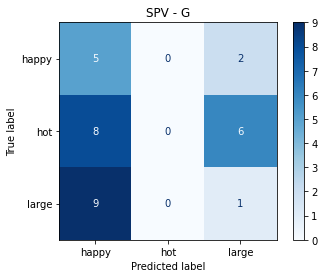

         ORL       ORL        ORL  ...        OYR        OYR        OYR
30 -0.141583 -0.224703  -0.307824  ...   -1.76244     -1.804   -1.84556
99 -0.282705 -0.256226  -0.123832  ...    2.12686    2.12686    2.12686
32 -0.445888 -0.418477  -0.418477  ...    1.96629    1.96629    1.96629
14  0.506352  0.565117   0.447588  ...  -0.668933  -0.668933  -0.668933
57 -0.550024 -0.550024  -0.550024  ...   -0.10442   -0.10442   -0.10442
..       ...       ...        ...  ...        ...        ...        ...
86  0.602433  0.602433   0.450686  ...   -1.52201   -1.44614   -1.37027
19 -0.933049 -0.933049  -0.933049  ...    1.80664    1.74835     1.7192
16  0.089441  0.089441  0.0287344  ... -0.0319721 -0.0319721 -0.0319721
71 -0.343189 -0.343189  -0.370527  ...    1.13309    1.13309    1.13309
89 -0.910143 -0.880283  -0.850422  ...     1.0905    1.18008     1.2398

[71 rows x 300 columns]
[[ 2.83635672 -0.33980164 -0.56164715 -1.88908608]
 [ 2.81891512 -0.29514033 -0.6022168  -1.90690193]
 [ 2.7720

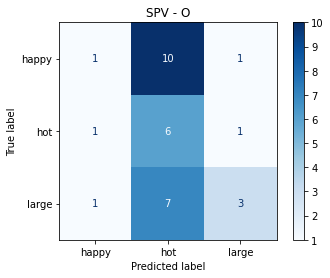

        EMG0L        EMG0L      EMG0L  ...       AZR       AZR       AZR
74  0.0743698  -0.00226275   -0.30849  ...   1.60889   1.44501   1.50184
63  0.0205776 -0.000626086  -0.143514  ...   1.33369   1.53418    1.5932
57  0.0900761  -0.00274062  -0.105476  ...  0.637179  0.939022   1.12756
10  0.0183708    0.0797506  -0.252974  ...   1.26297    1.2547   1.25562
67  0.0784642  -0.00238732  -0.267214  ...   1.32601   1.45348   1.36147
..        ...          ...        ...  ...       ...       ...       ...
85  0.0492009  -0.00149697   0.145915  ...   1.32987   1.43223   1.25101
59  0.0617351  -0.00187833 -0.0798932  ...  0.683569   1.06818   1.12162
31  0.0282662 -0.000860015   0.425738  ...   1.39109     1.344   1.15379
1   0.0451872  -0.00137485  -0.462039  ...  0.866574  0.843068  0.892039
95  0.0433094  -0.00131771   0.039679  ...   1.01443   1.02037  0.972866

[71 rows x 1100 columns]
[[-0.28896882 -0.11681702  0.09344307 ... -0.07134708  0.21759643
  -0.08356231]
 [-0.39304911 -0.

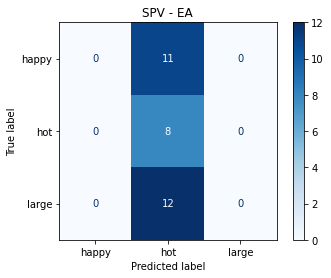

         EMG0L        EMG0L      EMG0L  ...        GZR        GZR        GZR
63   0.0205776 -0.000626086  -0.143514  ...  -0.399772  -0.673839  -0.815599
55   0.0433057   -0.0013176  -0.127301  ...   0.802475    0.26416 -0.0524964
73   0.0406878  -0.00123795  -0.262917  ...    1.89795    1.86487    1.13558
0    0.0480378  -0.00146158  -0.279052  ...  -0.234408  -0.223023  -0.226276
54   0.0856744  -0.00260669  -0.170771  ...  -0.347785   -1.08366   -1.38703
..         ...          ...        ...  ...        ...        ...        ...
42   0.0882901  -0.00268628    -0.2335  ...   -1.18744   -0.25435  -0.100252
94   0.0268709 -0.000817564   0.297502  ... -0.0469813 -0.0530888 -0.0391288
72 -0.00993134  0.000302167  -0.192202  ...    3.02939    2.12687    2.03298
85   0.0492009  -0.00149697   0.145915  ...   0.198056   0.104125   0.118576
50   0.0425557  -0.00129478 -0.0706014  ...  0.0133903   0.106229 -0.0794484

[71 rows x 1100 columns]
[[ 3.71353186e-01 -2.69949958e-02  6.83389418e-01 

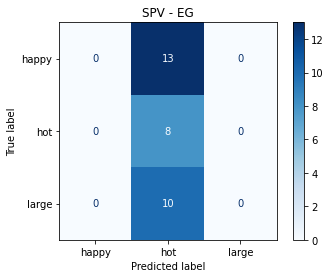

        EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
45  0.0189984 -0.000578038    1.16313  ...  -2.36596  -2.36596  -2.36596
46  0.0736083  -0.00223958    0.41757  ...  -2.34965  -2.34965  -2.34965
55  0.0433057   -0.0013176  -0.127301  ...   1.69979   1.69979   1.69979
3    0.015551 -0.000473147   0.117961  ...   1.53462   1.46197   1.42564
31  0.0282662 -0.000860015   0.425738  ...   2.03416   2.03416   2.03416
..        ...          ...        ...  ...       ...       ...       ...
59  0.0617351  -0.00187833 -0.0798932  ... -0.171175 -0.171175 -0.171175
82 -0.0153858  0.000468123  -0.644073  ...   1.64941   1.64941   1.64941
34  0.0470523   -0.0014316  -0.172498  ...   1.27895   1.27895   1.27895
67  0.0784642  -0.00238732  -0.267214  ...   1.99172   1.99172   1.99172
99  0.0706811  -0.00215052   0.637671  ...   2.12686   2.12686   2.12686

[71 rows x 1100 columns]
[[ 0.97079095  2.86573963 -0.09382418 ... -0.52580561 -0.20633316
  -0.12914832]
 [ 0.89976857  2.

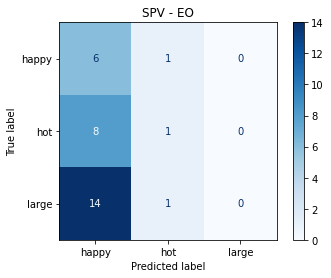

          AXL       AXL        AXL  ...         GZR        GZR         GZR
76  -0.820746 -0.722438 -0.0646873  ...   0.0215695  0.0954299   0.0496686
100  -1.96682  -1.99288   -1.28823  ...   -0.538295  -0.487026    -0.26894
60   -0.72502 -0.721518  -0.676872  ...  -0.0639662  -0.196035 -0.00817836
23  -0.797915 -0.864606  -0.744214  ...  -0.0236655  -0.813071   -0.861064
27   -1.61344  -1.72994   -1.76821  ...   -0.489584  -0.378278   -0.346371
..        ...       ...        ...  ...         ...        ...         ...
79   0.196472  0.316714   0.569137  ...  0.00596487 -0.0345802  -0.0280053
91  -0.921533   -1.0875  -0.416143  ...   -0.231903 -0.0601553  -0.0775917
12   -1.17792  -1.11092  -0.968209  ...  -0.0310408 -0.0168532  -0.0220123
26   -0.64008  -0.70292  -0.970863  ...     0.71436   0.246838   -0.675241
51  -0.507244 -0.518925  -0.510581  ...   -0.637294  -0.743934   -0.857346

[71 rows x 600 columns]
[[ 0.4049332   1.02808907  2.97097732 ... -0.69153408 -0.56043014
  -0.3422

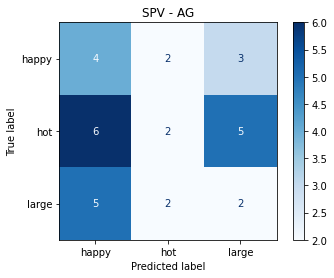

         AXL       AXL        AXL  ...       OYR        OYR       OYR
63  0.839235  0.844154   0.809715  ...  -1.80304   -1.80304   2.12154
36  -1.32384   -1.3153   -1.32299  ...  0.919255   0.919255  0.919255
66   -1.1631  -1.14783   -1.15122  ...   2.00857    2.00857   2.03338
99  -0.48694 -0.334788 -0.0518391  ...   2.12686    2.12686   2.12686
73  0.343857  0.359631   0.375407  ...   2.09356   -2.47126  -2.36693
..       ...       ...        ...  ...       ...        ...       ...
72  0.508162  0.856429   0.287729  ...   1.57482    1.72882   1.93415
31   -2.1525  -1.43258    -1.1455  ...   2.03416    2.03416   2.03416
32  0.885556  0.964881   0.952939  ...   1.96629    1.96629   1.96629
69  -1.68135  -1.62231   -1.40674  ...   1.27875    1.27875   1.27875
15 -0.507835 -0.554213  -0.468912  ...  0.201526  0.0328066 -0.135913

[71 rows x 600 columns]
[[-0.97023115 -0.83932799  3.29095058 -0.76777655 -1.71362462 -0.88903894]
 [-0.97211166 -0.83642942  3.29378326 -0.76831746 -1.7036082

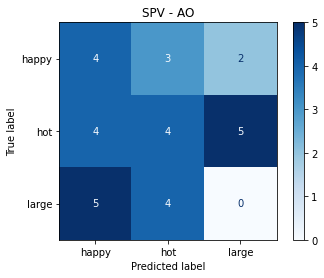

           GXL         GXL        GXL  ...      OYR      OYR      OYR
70     0.19993    0.332339 -0.0167403  ...  1.18589  1.18589  1.18589
4     0.224163    -1.43292   -1.06776  ... -1.92214 -1.92214 -1.92214
22  -0.0811677   -0.236416  -0.654829  ...   1.9869  1.93084  1.90281
47  -0.0975245  0.00470025   -0.18171  ...  -1.7109  -1.7109  -1.7109
25    0.626337    -2.47737    1.42223  ...  1.36774  1.41307  1.41307
..         ...         ...        ...  ...      ...      ...      ...
96    0.437435    0.441237  -0.400002  ...  2.18282  2.15558  2.15558
90     1.05106     0.99171     1.6497  ...  1.02566  1.08557  1.20539
23   -0.165163   -0.166818  -0.206536  ...  1.26152   1.1691  1.07668
5      1.04765    0.187797  -0.797228  ... -1.97271 -1.97271 -1.97271
26 -0.00204534   -0.167968  -0.430679  ...   1.5497   1.5497  1.45922

[71 rows x 600 columns]
[[-1.18438474 -0.12037347  0.08607767 ...  0.87914743 -0.66695944
   0.52663103]
 [-1.18163238 -0.14985564  0.12818295 ...  0.90559151 

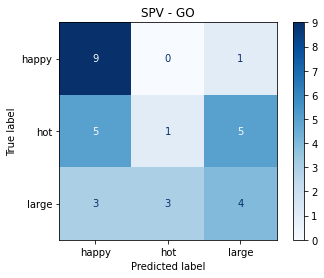

        EMG0L        EMG0L      EMG0L  ...         GZR        GZR        GZR
52  0.0324582 -0.000987561 -0.0522937  ...   -0.675218  -0.980805  -0.938596
25  0.0324087 -0.000986054  0.0764913  ...     2.45102   0.859235    1.07192
78  0.0992365  -0.00301933  -0.445273  ...    0.237328 -0.0235001  -0.100214
70  0.0853627  -0.00259721   0.155648  ...   0.0365675  0.0382871   0.003895
13  0.0694256  -0.00211231   0.083671  ...  -0.0632431 -0.0528838 -0.0497761
..        ...          ...        ...  ...         ...        ...        ...
99  0.0706811  -0.00215052   0.637671  ... -0.00839945  -0.028319 -0.0631782
10  0.0183708    0.0797506  -0.252974  ...    -0.10119  -0.117258  -0.126632
12  0.0534615   -0.0016266    0.22343  ...  -0.0310408 -0.0168532 -0.0220123
83  0.0545331   -0.0016592   0.318526  ...     1.57025    1.12591    1.06352
44  0.0744505   -0.0022652  -0.116668  ...   -0.630717  -0.392952   -0.20651

[71 rows x 1400 columns]
[[ 0.74414426  0.0041401   0.04301885 ...  0.46113

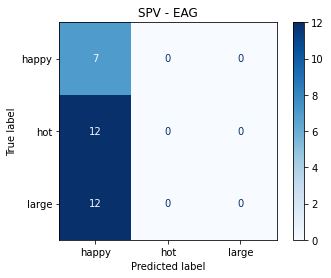

        EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
23  0.0373005 -0.00113489  0.0170284  ...   1.26152    1.1691   1.07668
60  0.0423697 -0.00128912 -0.0690925  ... -0.192226 -0.192226 -0.192226
17  0.0883472 -0.00268802 -0.0461767  ... -0.377771 -0.377771 -0.377771
41   0.108847 -0.00331175   -0.14836  ...  0.543318  0.543318  0.543318
14   0.058362  -0.0017757   -2.61784  ... -0.668933 -0.668933 -0.668933
..        ...         ...        ...  ...       ...       ...       ...
91   0.081744 -0.00248711 -0.0427253  ...   0.15615   0.15615  0.110133
99  0.0706811 -0.00215052   0.637671  ...   2.12686   2.12686   2.12686
95  0.0433094 -0.00131771   0.039679  ...   2.21455   2.21455   2.18714
51  0.0461984 -0.00140561  -0.116313  ... -0.346949 -0.459717 -0.572485
33  0.0818821 -0.00249131   0.131729  ...   2.04065   2.04065   2.04065

[71 rows x 1400 columns]
[[-0.8081922  -0.86382191 -0.05574984 ...  0.2752442  -0.01399864
  -0.09549251]
 [-0.85432727 -0.8378987   0.

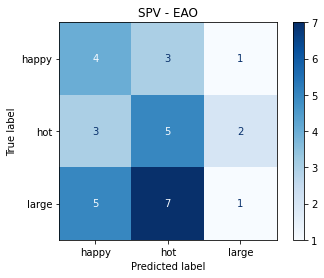

         EMG0L        EMG0L       EMG0L  ...      OYR      OYR      OYR
73   0.0406878  -0.00123795   -0.262917  ...  2.09356 -2.47126 -2.36693
48   0.0502059  -0.00152754   0.0682639  ... -1.73785 -1.73785 -1.73785
95   0.0433094  -0.00131771    0.039679  ...  2.21455  2.21455  2.18714
70   0.0853627  -0.00259721    0.155648  ...  1.18589  1.18589  1.18589
35    0.100768  -0.00306591   -0.121569  ...  1.14744  1.11782  1.11782
..         ...          ...         ...  ...      ...      ...      ...
6    0.0156398  -0.00047585  -0.0964413  ... -1.85773 -1.85773 -1.82608
22  0.00612356 -0.000186313 -0.00320061  ...   1.9869  1.93084  1.90281
26   0.0169569 -0.000515925   0.0650638  ...   1.5497   1.5497  1.45922
67   0.0784642  -0.00238732   -0.267214  ...  1.99172  1.99172  1.99172
77   0.0894049   -0.0027202    -1.75108  ...  1.25442  1.28988  1.28988

[71 rows x 1400 columns]
[[ 0.01400928  2.03964862  0.44077853 ... -0.27224774 -0.15085627
  -0.71028071]
 [ 0.02867844  2.04727086  0.

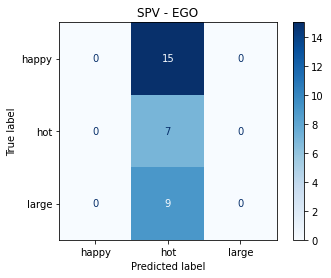

         AXL       AXL       AXL  ...        OYR        OYR        OYR
83 -0.642468 -0.615532 -0.740654  ...   -1.31138   -1.24009   -1.24009
73  0.343857  0.359631  0.375407  ...    2.09356   -2.47126   -2.36693
96    1.1465   1.02463   1.23189  ...    2.18282    2.15558    2.15558
36  -1.32384   -1.3153  -1.32299  ...   0.919255   0.919255   0.919255
24 -0.504482 -0.488851 -0.558322  ...    1.05354    1.38272     1.5238
..       ...       ...       ...  ...        ...        ...        ...
45  -1.04281  -1.05946  -1.05724  ...   -2.36596   -2.36596   -2.36596
13  0.471031  0.175567 -0.694616  ...  -0.614014  -0.614014   -0.67513
64  -1.12976   -1.1155  -1.11634  ...    1.92137    1.92137    1.92137
6   0.965165   1.03539 -0.361854  ...   -1.85773   -1.85773   -1.82608
16  -0.61941 -0.616025 -0.781907  ... -0.0319721 -0.0319721 -0.0319721

[71 rows x 900 columns]
[[ 2.42963736 -0.06470778 -1.59708552 ... -0.35417692 -0.06202487
   0.24193988]
 [ 2.4371639  -0.01564559 -1.57873782 ... 

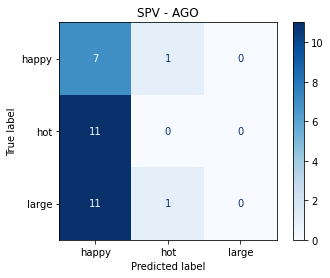

         EMG0L        EMG0L       EMG0L  ...       OYR       OYR       OYR
47   0.0430739  -0.00131055    0.275834  ...   -1.7109   -1.7109   -1.7109
40   0.0697413  -0.00212192   -0.199908  ...  -1.99894  -1.99894  -1.99894
55   0.0433057   -0.0013176   -0.127301  ...   1.69979   1.69979   1.69979
8    0.0429738   -0.0013075   -0.237666  ...  0.329036  0.387307  0.387307
61   0.0427288  -0.00130005  -0.0223332  ... -0.230687 -0.230687 -0.230687
..         ...          ...         ...  ...       ...       ...       ...
22  0.00612356 -0.000186313 -0.00320061  ...    1.9869   1.93084   1.90281
70   0.0853627  -0.00259721    0.155648  ...   1.18589   1.18589   1.18589
96   0.0442954  -0.00134771   -0.224114  ...   2.18282   2.15558   2.15558
65   0.0843766  -0.00256721     0.15983  ...   1.95426   1.95426   1.92922
18   0.0559427  -0.00170209  -0.0292397  ... -0.210028 -0.210028 -0.210028

[71 rows x 1700 columns]
[[ 0.24742956  2.83217197 -0.16625352 ... -0.02624745  0.70158435
  -0.174

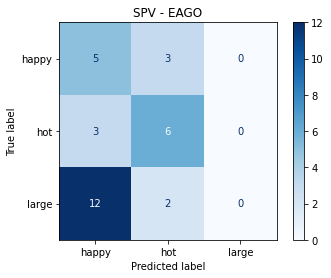

   EMG0L     EMG0L     EMG0L      EMG0L  ...     EMG7R     EMG7R     EMG7R     EMG7R
38     0         0  0.355984   0.334322  ...  0.460872 -0.940764  0.610357  -1.67574
10     0  0.711968   -2.8912    2.27758  ...   8.12863  -9.18087   6.99907   8.48454
87     0         0   2.13591   -1.19793  ...   3.72318  0.406861  -5.17607  -5.03801
14     0         0   -23.495    52.6914  ...  -5.73763  -6.76445   2.43584  -2.36622
46     0         0   2.84787    -9.0729  ...   3.40064   2.00482  -4.10313   11.4188
..   ...       ...       ...        ...  ...       ...       ...       ...       ...
86     0         0  -1.42394  0.0866483  ...  -26.4033  -1.53378  -10.3159  0.981771
64     0         0 -0.355984   0.377646  ...   3.45717  0.363167    4.6766   4.67889
39     0         0  -1.06795    1.13294  ...  -2.32136  -2.42932  -2.76671  -2.88447
31     0         0   3.20386   -9.80653  ...  -4.67382   1.44537   2.24623  -3.06099
43     0         0  0.355984    -1.4456  ...  -2.46644  -1.05218 

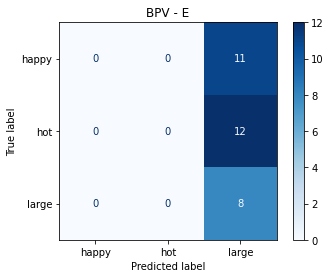

          AXL         AXL        AXL  ...       AZR       AZR       AZR
37   0.543457    0.567383   0.495117  ...  0.973633  0.939941  0.984375
49 -0.0454102 -0.00683594  0.0175781  ...    1.0249   1.02344   1.02393
87 -0.0737305  -0.0712891 -0.0825195  ...  0.768555  0.786133  0.884277
18  -0.097168   -0.167969  -0.160156  ...   1.00049   0.97168   0.91748
72   0.369629    0.577148   0.238281  ...  0.332031  0.918457    1.1377
..        ...         ...        ...  ...       ...       ...       ...
11  -0.170898     0.10791   0.236816  ...  0.958496  0.966309  0.969727
43  -0.504883   -0.505859  -0.497559  ...  0.835938  0.816895  0.817871
53  -0.204102    -0.20166  -0.201172  ...  0.850098  0.844238  0.891602
39   0.525391    0.556152   0.546387  ...  0.984375  0.950684  0.969727
42  -0.501953   -0.500488   -0.48291  ...    1.2041   1.17041  0.973145

[71 rows x 300 columns]
[[-0.50984373  0.3710061   0.09523498 -0.01773877  0.16882922]
 [-0.49756833  0.41101898  0.10934768 -0.0020230

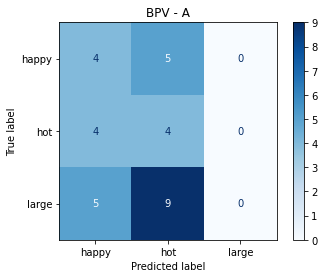

        GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
33  146.688  128.312       77   86.625  ...   0.6875  -0.3125  -0.9375  -1.1875
84  -42.125     4.25 -14.0625  -32.625  ...   63.625    52.25   55.375  51.6875
21   33.125    7.375     -5.5 -12.4375  ...   -66.75 -67.8125 -69.9375 -75.3125
11   -3.375  -27.875 -58.9375  -26.125  ...    0.375       -1    0.125   0.0625
76   63.875  92.0625       78   93.125  ...     15.5    1.125    6.875   3.3125
..      ...      ...      ...      ...  ...      ...      ...      ...      ...
92  37.5625  46.6875  44.1875   54.625  ... -44.0625      -35 -14.8125  -15.625
9   36.5625  27.0625  71.0625  66.9375  ...        5  -1.9375   9.8125    8.625
5   59.3125   9.9375  -46.625    -8.75  ...   -1.125  -0.3125    3.875   2.3125
20 -26.6875  -5.1875  14.9375  15.6875  ... -76.3125  -67.125 -56.1875   -54.75
30  -53.875 -85.9375 -108.188  -112.25  ...  -61.375  -38.125  -44.625  -40.375

[71 rows x 300 columns]
[[  72.50691484

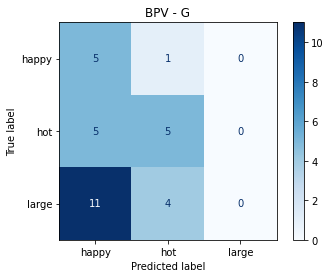

    ORL  ORL  ORL  ORL  ORL  ORL  ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR
0    83   85   84   84   86   87   89  ...  130  130  129  128  128  127  127
49   89   89   88   88   88   88   88  ...   69   69   69   69   69   69   69
35   84   84   84   85   85   85   85  ...  144  142  141  139  138  137  137
74   85   86   86   84   79   76   75  ...  169  176    0    5    7    8    9
97  101  101  102  103  103  104  105  ...  167  169  170  171  171  170  169
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
22   64   64   63   62   62   61   61  ...  176  174  171  169  167  165  164
43   76   76   76   76   76   76   76  ...  120  120  120  120  120  120  120
72   87   87   86   86   86   84   84  ...  139  141  147  154  165  171  179
25   69   68   70   73   76   77   78  ...   99  101  102  106  111  112  112
14   88   89   87   87   87   87   86  ...   68   68   68   68   68   68   68

[71 rows x 300 columns]
[[-39.05523639  -5.05605373 -13.1558515

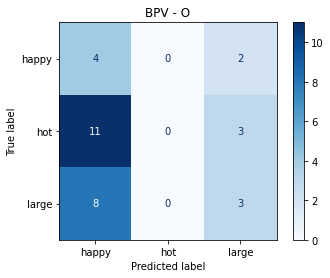

   EMG0L EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR       AZR
82     0     0  -5.69575   10.3142  ...  0.831543   0.79248  0.800781  0.787598
93     0     0 -0.711968  0.755293  ...   1.07715   1.10156    1.0498   1.14844
78     0     0  -1.77992   1.53225  ...  0.741699  0.740723  0.814941  0.841309
0      0     0  -2.13591  -4.85381  ...  0.813477  0.807129  0.780762  0.813965
29     0     0         0 -0.711968  ...   1.05127   1.03369  0.950684  0.841309
..   ...   ...       ...       ...  ...       ...       ...       ...       ...
69     0     0   2.49189  -7.98329  ...  0.870605  0.804688  0.783203  0.786133
50     0     0 -0.355984    1.4456  ...  0.814941  0.801758  0.808105  0.804688
74     0     0  -4.27181  -25.3709  ...   1.14307   1.05859  0.961426  0.995117
11     0     0  -5.33976   8.51257  ...  0.956543  0.958496  0.966309  0.969727
31     0     0   3.20386  -9.80653  ...   1.08154   1.02441  0.998535  0.894043

[71 rows x 1100 columns]
[[  9.19145362

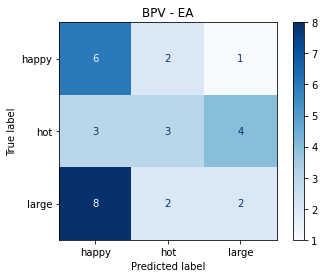

   EMG0L EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR      GZR
43     0     0  0.355984   -1.4456  ...  -1.5625    2.875   0.3125    0.875
88     0     0  0.355984  -2.15757  ...  122.562  130.125   117.75   112.25
81     0     0  0.711968  -4.31513  ...   2.0625   1.6875   -0.625        1
79     0     0   16.0193  -16.9941  ...   -2.375  -3.1875     -5.5   -5.125
50     0     0 -0.355984    1.4456  ...   2.1875     0.25      3.5       -3
..   ...   ...       ...       ...  ...      ...      ...      ...      ...
73     0     0  -3.55984   8.40426  ...  211.125  157.125  154.375    93.75
54     0     0 -0.711968  0.755293  ...    6.625 -12.6875   -42.25 -54.4375
13     0     0   1.06795   10.6145  ...  -2.5625   -2.125     -1.5  -1.3125
72     0     0  -2.84787    2.3092  ...  221.438  245.062  170.562  162.812
21     0     0         0  -1.77992  ...   -66.75 -67.8125 -69.9375 -75.3125

[71 rows x 1100 columns]
[[ -0.46461774  -0.40311405   1.21373357 ...  -2.42531503   2.

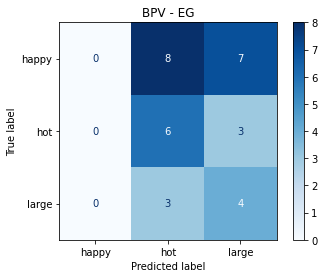

   EMG0L EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
65     0     0   1.06795  -2.55688 -0.251787  ...  173  173  173  173  172
21     0     0         0  -1.77992   3.66815  ...  170  168  166  164  162
89     0     0   3.20386  -7.67063   3.16047  ...  123  125  130  133  135
26     0     0  0.711968  -3.95915   3.05453  ...  115  115  116  116  114
43     0     0  0.355984   -1.4456   1.13879  ...  120  120  120  120  120
..   ...   ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
23     0     0  0.355984  0.334322  -1.10543  ...  106  106  105  103  101
71     0     0   3.55984  -6.26835  -1.21381  ...  140  140  139  139  139
15     0     0 -0.711968  0.755293 -0.367683  ...   79   78   74   71   68
11     0     0  -5.33976   8.51257   7.21463  ...   77   77   77   77   77
18     0     0         0         0  -1.06795  ...   65   65   66   66   66

[71 rows x 1100 columns]
[[-79.9574976  -30.84612753  33.94379403 ...   0.73705535  -2.84996504
   

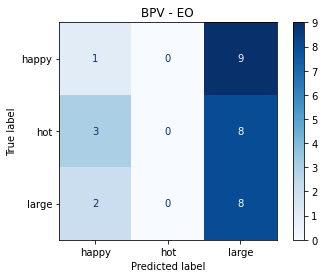

          AXL         AXL        AXL  ...      GZR      GZR      GZR
57  -0.196289   -0.191406  -0.202148  ...      -10  -9.0625        4
2   -0.616699   -0.597168   -0.76709  ... -27.6875 -22.3125  -8.1875
30   -0.59375   -0.611816  -0.655273  ...  -38.125  -44.625  -40.375
67  -0.533691   -0.535156  -0.550781  ... -83.6875 -50.3125 -43.0625
23  -0.176758   -0.214355  -0.146484  ...    -0.75  -60.375      -64
..        ...         ...        ...  ...      ...      ...      ...
68  -0.461426    -0.45459  -0.445801  ...     5.25  -9.4375    -13.5
49 -0.0454102 -0.00683594  0.0175781  ...    0.125   0.3125      0.5
85  -0.215332   0.0229492  -0.090332  ...   10.125   6.0625   6.6875
34  -0.552734   -0.534668  -0.541992  ...  -3.1875  -2.9375   -0.375
13    0.56543    0.414062 -0.0317383  ...   -2.125     -1.5  -1.3125

[71 rows x 600 columns]
[[ 0.62038048  0.4966616  -0.40378926  3.93384128 -3.26686791]
 [ 0.81287814  0.25851538 -1.02949632  3.33322046 -3.08131759]
 [ 0.61452052  1.2731

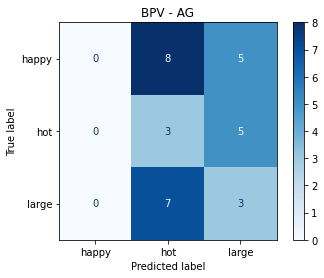

          AXL       AXL       AXL        AXL  ...  OYR  OYR  OYR  OYR
10   0.482422 -0.123047  -0.27832  -0.296875  ...   77   77   77   77
92   0.090332   0.15332  0.257324   0.293457  ...   79   78   78   78
38   0.519531  0.541504   0.53125   0.552734  ...   15   15   14   14
57  -0.196289 -0.191406 -0.202148  -0.198242  ...   84   84   84   84
83  -0.176758 -0.161621 -0.231934  -0.336426  ...   48   48   49   49
..        ...       ...       ...        ...  ...  ...  ...  ...  ...
58  -0.194824 -0.201172 -0.192871  -0.200684  ...   83   83   83   83
100 -0.791504 -0.805664 -0.422852  -0.226562  ...  165  166  168  169
3   -0.555176 -0.554199 -0.589355  -0.539551  ...  138  137  135  134
34  -0.552734 -0.534668 -0.541992  -0.561035  ...  140  140  140  140
31  -0.922363 -0.526855 -0.369141 -0.0292969  ...  173  172  172  172

[71 rows x 600 columns]
[[ 48.34721207 -18.88738347  -5.68218123  49.64180104]
 [ 39.78212691 -11.98034076   1.75734224  32.16805143]
 [ 33.0283052  -14.403233

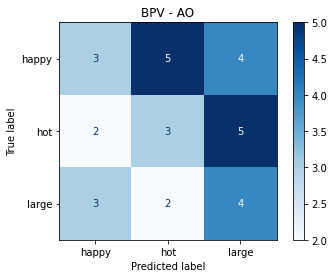

        GXL     GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
84  -42.125    4.25 -14.0625  -32.625       -3  ...   49   50   50   51   51
55  -2.1875 -3.4375     -3.5  -0.9375   -3.125  ...  156  157  157  157  157
47  -1.9375  2.3125  -5.4375    -0.75  -6.6875  ...   70   70   70   70   70
68   2.4375   6.125   0.3125  29.9375  11.8125  ...  143  143  144  143  143
56    0.125 -0.8125       -2  -4.1875   -4.875  ...  154  155  155  156  156
..      ...     ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
45   -0.125   -2.25  -1.3125  -2.5625  -1.0625  ...   28   28   28   28   28
31 -34.0625 -5.6875  103.625    143.5   97.875  ...  173  173  172  172  172
44    1.375   5.125   0.6875  -6.6875   5.8125  ...  123  122  122  122  122
61   0.0625   0.625   -3.875     -3.5   5.5625  ...   81   80   80   80   80
66   4.3125  5.5625  -6.0625   -2.375   2.9375  ...  173  172  172  172  173

[71 rows x 600 columns]
[[ -2.67415954   4.85582544  27.18270864 ...  12.68

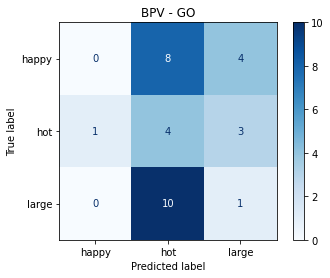

   EMG0L EMG0L     EMG0L     EMG0L  ...      GZR      GZR      GZR      GZR
5      0     0   3.55984  -3.42048  ...   -1.125  -0.3125    3.875   2.3125
23     0     0  0.355984  0.334322  ...  35.5625    -0.75  -60.375      -64
30     0     0         0         0  ...  -61.375  -38.125  -44.625  -40.375
11     0     0  -5.33976   8.51257  ...    0.375       -1    0.125   0.0625
70     0     0   1.42394 -0.442632  ...    4.875    7.375      7.5        5
..   ...   ...       ...       ...  ...      ...      ...      ...      ...
54     0     0 -0.711968  0.755293  ...    6.625 -12.6875   -42.25 -54.4375
82     0     0  -5.69575   10.3142  ...  -4.1875  -2.6875  -0.4375  -1.8125
58     0     0         0         0  ...    1.125   9.6875  -7.9375  -5.1875
56     0     0 -0.711968   1.11128  ...    10.25  27.1875    41.25    37.25
15     0     0 -0.711968  0.755293  ... -144.562 -116.938 -31.5625     14.5

[71 rows x 1400 columns]
[[-8.21070462e+00 -1.55511651e+01 -2.98496881e+01 ...  1.00435

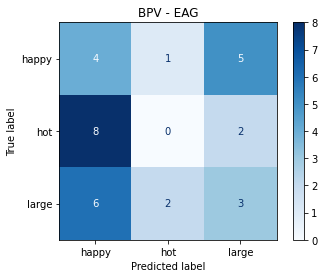

   EMG0L    EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
72     0        0  -2.84787    2.3092   2.13243  ...  147  154  165  171  179
93     0        0 -0.711968  0.755293  0.344285  ...   79   79   78   78   78
37     0 -1.42394   2.57854   1.69154  -4.34445  ...   15   15   15   15   15
92     0        0   3.55984  -8.40426  -1.08383  ...   79   79   78   78   78
82     0        0  -5.69575   10.3142   5.34221  ...  156  156  156  156  156
..   ...      ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
98     0        0   3.91583  -7.71395  -2.56691  ...  171  172  173  173  174
1      0        0  -3.91583   9.49387   6.01844  ...  131  130  129  129  128
28     0        0  -1.06795   2.20089 -0.794503  ...   41   41   40   39   38
78     0        0  -1.77992   1.53225   5.33218  ...  124  124  125  126  126
62     0        0         0         0 -0.355984  ...  179  179  179  179  178

[71 rows x 1400 columns]
[[ 90.23071592  21.81391153  12.277477

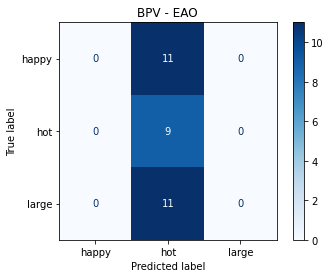

   EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
60     0     0 -0.355984   0.733631 -0.383496  ...   81   81   81   81   81
91     0     0         0    1.77992  -5.09209  ...   77   77   77   77   76
57     0     0 -0.355984  0.0216621  0.727781  ...   84   84   84   84   84
66     0     0 -0.355984   0.377646  0.706119  ...  173  172  172  172  173
71     0     0   3.55984   -6.26835  -1.21381  ...  140  140  139  139  139
..   ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
24     0     0 -0.355984  0.0216621  0.371797  ...   96   99  102  109  112
94     0     0   1.77992   -3.31217  -1.66402  ...   79   79   79   79   79
32     0     0  0.711968   -1.46726  -1.01293  ...  172  172  172  172  172
21     0     0         0   -1.77992   3.66815  ...  170  168  166  164  162
85     0     0   1.06795    3.85084  -24.1367  ...   54   54   54   53   53

[71 rows x 1400 columns]
[[  0.23881386   3.3459317   -2.09116423 ...  41.96788428 -31.

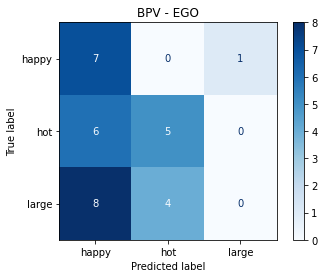

          AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
42  -0.501953  -0.500488   -0.48291  -0.492676  ...  119  119  118  118
56 -0.0673828    -0.0625 -0.0571289 -0.0507812  ...  155  155  156  156
85  -0.215332  0.0229492  -0.090332   0.114746  ...   54   54   53   53
59  -0.217285  -0.217285  -0.189941  -0.193848  ...   82   82   82   82
18  -0.097168  -0.167969  -0.160156  -0.166016  ...   65   66   66   66
..        ...        ...        ...        ...  ...  ...  ...  ...  ...
11  -0.170898    0.10791   0.236816   0.172363  ...   77   77   77   77
87 -0.0737305 -0.0712891 -0.0825195 -0.0410156  ...  112  113  114  117
41  -0.502441   -0.50293  -0.486328  -0.498047  ...  114  114  114  114
26 -0.0898438     -0.125  -0.274902 -0.0791016  ...  115  116  116  114
7    0.670898   0.590332   0.597168   0.466309  ...   11   10   10    9

[71 rows x 900 columns]
[[ -3.18661157   2.07006148  -1.11432778 ...  -6.87324895 -13.87818982
  -19.79445383]
 [ -2.62419914   2.26532

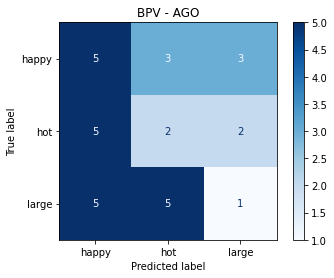

   EMG0L     EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
14     0         0   -23.495   52.6914  -10.9753  ...   68   68   68   68   68
50     0         0 -0.355984    1.4456  -2.56273  ...   71   70   70   69   69
68     0         0  -4.27181   4.88774    7.7398  ...  143  143  144  143  143
84     0         0  -1.42394  0.442632   5.38135  ...   49   50   50   51   51
39     0         0  -1.06795   1.13294   2.83032  ...   15   14   14   14   14
..   ...       ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
43     0         0  0.355984   -1.4456   1.13879  ...  120  120  120  120  120
62     0         0         0         0 -0.355984  ...  179  179  179  179  178
71     0         0   3.55984  -6.26835  -1.21381  ...  140  140  139  139  139
74     0         0  -4.27181  -25.3709   84.6937  ...    0    5    7    8    9
10     0  0.711968   -2.8912   2.27758   3.66118  ...   77   77   77   77   77

[71 rows x 1700 columns]
[[ 24.16149844  61.4482698

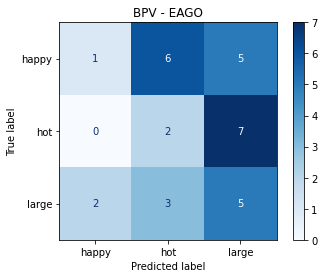

       EMG0L     EMG0L     EMG0L  ...       EMG7R       EMG7R        EMG7R
32  0.118661 -0.125882 -0.111318  ...   0.0013669  0.00629258  0.000105216
22  0.168053  -0.17828 -0.165292  ...  0.00177009   -0.063332    -0.029615
84  0.169399 -0.179708 -0.176436  ...    0.035677   0.0472399   -0.0331478
83  0.202349 -0.214662 -0.185909  ...  -0.0189841 -0.00305518   -0.0154835
87  0.175437 -0.186113 -0.162335  ...   0.0019467  -0.0247659   -0.0241053
..       ...       ...       ...  ...         ...         ...          ...
28  0.215199 -0.228295 -0.217697  ...    0.115049  0.00555179   -0.0318661
72  0.184077 -0.195279 -0.193223  ... -0.00485672  -0.0268369     0.062984
80  0.175992 -0.186702   -0.1831  ... -0.00624164 -0.00730745   -0.0284016
71  0.263961 -0.280023 -0.235407  ...   0.0515614   0.0281546   0.00315176
38   0.17495 -0.185595 -0.170553  ... -0.00402036  0.00260836  -0.00716129

[71 rows x 800 columns]
[[-2.52992947e-02  6.06177132e-02 -4.37276059e-02 ...  5.64325582e-03
  -3.

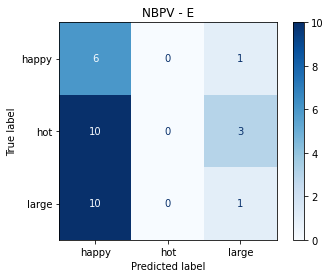

          AXL        AXL         AXL  ...       AZR       AZR       AZR
20   0.490321   0.543001    0.528854  ...  0.796166  0.812361  0.811244
76   0.301627   0.323235    0.467811  ...  0.842506   0.86946  0.871467
89   0.461322   0.576058    0.547536  ...  0.888503  0.953973  0.971046
65   0.093274   0.100465   0.0856599  ...  0.679991  0.647207  0.662224
31          0   0.167355     0.23409  ...  0.823758  0.812809  0.768594
..        ...        ...         ...  ...       ...       ...       ...
36   0.141005    0.14332    0.141237  ...  0.769159  0.788377  0.789766
26     0.3646   0.352475    0.300774  ...   0.70512   0.71674  0.691647
43  0.0354796  0.0349543   0.0394217  ...  0.757162  0.746912  0.747437
28  0.0317389          0  0.00919953  ...  0.898805  0.895816  0.907543
42  0.0151061  0.0159301   0.0258174  ...  0.974733  0.955783  0.844825

[71 rows x 300 columns]
[[ 0.02462848 -0.06873089 -0.1695344   0.04774309 -0.10996343]
 [ 0.06230195 -0.09368852 -0.16465328  0.0764460

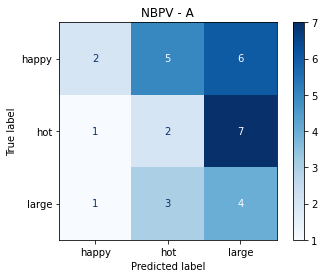

         GXL       GXL       GXL  ...       GZR       GZR       GZR
34  0.482822  0.481423  0.462148  ...  0.465568  0.466189  0.472563
20  0.371792  0.436223  0.496534  ...  0.250608  0.283386  0.287694
16  0.639377  0.640244  0.534547  ...  0.649341  0.676198  0.681179
30  0.379708  0.295347  0.236803  ...  0.421149  0.404046  0.415229
86  0.548646  0.516062  0.481643  ...  0.630794  0.670721  0.709959
..       ...       ...       ...  ...       ...       ...       ...
60  0.437768  0.438286  0.438027  ...  0.433494   0.41847   0.43984
70  0.490418   0.51135  0.456165  ...  0.464592  0.464864  0.459427
11  0.520589  0.461677  0.386985  ...    0.5263  0.529005  0.528855
48  0.558146  0.574997  0.583961  ...  0.586949  0.586471  0.585515
39  0.457828   0.45705  0.459695  ...  0.451759  0.448024    0.4446

[71 rows x 300 columns]
[[-0.0528498   0.02618053  0.01496086  0.01756082  0.00321317]
 [-0.05484982  0.02623345  0.01695707  0.01886243  0.00253951]
 [-0.01995034  0.01132664  0.0486

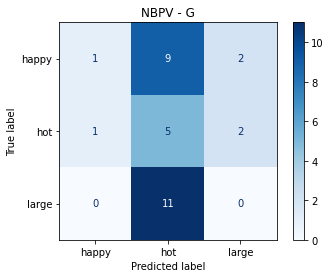

          ORL       ORL       ORL  ...        OYR        OYR        OYR
101  0.307143  0.314286      0.35  ...   0.964286   0.964286   0.964286
68   0.277778  0.277778  0.277778  ...   0.793651   0.785714   0.785714
50   0.553846  0.553846  0.553846  ...   0.507692   0.492308   0.492308
79   0.468208  0.462428  0.456647  ...   0.913295   0.907514   0.907514
59   0.311688  0.311688  0.324675  ...   0.415584   0.415584   0.415584
..        ...       ...       ...  ...        ...        ...        ...
46   0.863014  0.863014  0.863014  ...  0.0136986  0.0136986  0.0136986
0    0.287129  0.306931   0.29703  ...   0.732673   0.722772   0.722772
21   0.108527  0.108527  0.108527  ...   0.906977   0.891473   0.875969
87      0.125     0.125     0.125  ...   0.541667       0.55      0.575
71   0.340741  0.340741  0.333333  ...   0.740741   0.740741   0.740741

[71 rows x 300 columns]
[[-0.32416174 -0.18482554  0.1167859  -0.16428686]
 [-0.33108569 -0.17039063  0.10721321 -0.18245858]
 [-0.3593

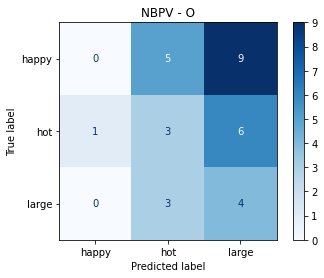

       EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR
3   0.154958 -0.164387 -0.146129  ...   0.84395  0.794081  0.794797
62  0.183441 -0.194603 -0.180427  ...  0.936043  0.992325   0.99079
15  0.189636 -0.201176 -0.189847  ...  0.574694   0.69345  0.991753
20  0.171057 -0.181466 -0.169788  ...  0.796166  0.812361  0.811244
61  0.146818 -0.155752 -0.144406  ...  0.789512  0.852783  0.875471
..       ...       ...       ...  ...       ...       ...       ...
32  0.118661 -0.125882 -0.111318  ...  0.828232  0.826862  0.832115
57  0.222175 -0.235694 -0.221048  ...  0.697523  0.775373  0.824001
75     0.202 -0.214292 -0.246698  ...  0.979101  0.990662         1
60  0.160013  -0.16975 -0.159182  ...  0.715002  0.803657  0.867018
12  0.196556 -0.208516 -0.178038  ...  0.839709  0.839166   0.84215

[71 rows x 1100 columns]
[[-0.04765172  0.34525311 -0.01203432 ... -0.03653947  0.0290541
   0.07614898]
 [-0.0405408   0.33937836 -0.01745269 ...  0.02328548  0.02158413
  -0.0065770

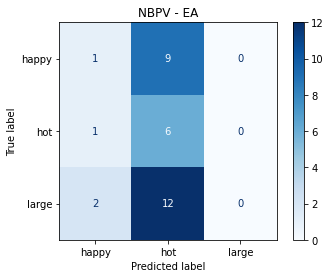

       EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
20  0.171057 -0.181466 -0.169788  ...  0.250608  0.283386  0.287694
12  0.196556 -0.208516 -0.178038  ...  0.475674  0.477452  0.476806
65  0.159057 -0.168736 -0.148869  ...  0.376688  0.357336  0.362586
77  0.271226 -0.287731 -0.328219  ...  0.609381  0.590939  0.584124
78  0.201953 -0.214242 -0.215749  ...  0.535652  0.492013  0.479177
..       ...       ...       ...  ...       ...       ...       ...
24  0.200475 -0.212674 -0.199055  ...  0.797395         1   0.68518
95  0.146765 -0.155696 -0.141231  ...   0.60901   0.56807  0.552121
82   0.18019 -0.191154 -0.212388  ...  0.622333  0.628576  0.624761
91   0.20911 -0.221834 -0.205673  ...  0.450726  0.479359  0.476452
72  0.184077 -0.195279 -0.193223  ...         1  0.865021  0.850979

[71 rows x 1100 columns]
[[-0.05538738  0.05001906 -0.01857049 ...  0.02123466 -0.01027939
  -0.05185376]
 [-0.07108649  0.04129248  0.01112938 ...  0.00255941  0.006083
   0.00480104

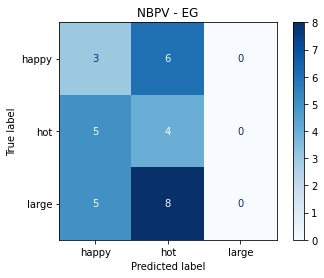

       EMG0L     EMG0L     EMG0L  ...       OYR       OYR       OYR
56  0.215348 -0.228453 -0.216205  ...  0.865922  0.871508  0.871508
67  0.196885 -0.208866 -0.201605  ...   0.97191   0.97191   0.97191
69  0.206968 -0.219562  -0.18425  ...  0.770492  0.770492  0.770492
63  0.110803 -0.117546 -0.113697  ...         0         0         1
91   0.20911 -0.221834 -0.205673  ...  0.533333  0.533333  0.522222
..       ...       ...       ...  ...       ...       ...       ...
49  0.203788 -0.216189 -0.148847  ...  0.391304  0.391304  0.391304
10  0.190128 -0.197652 -0.203431  ...  0.444444  0.444444  0.444444
52  0.162632 -0.172529 -0.161767  ...    0.4375   0.40625     0.375
90  0.191454 -0.203104 -0.191299  ...     0.675  0.691667     0.725
54  0.189353 -0.200876 -0.191291  ...  0.871508  0.865922  0.860335

[71 rows x 1100 columns]
[[-0.14111629 -0.02300084 -0.21230642 ...  0.11125373  0.05797211
   0.06566785]
 [-0.1400303  -0.0184324  -0.20868603 ... -0.06244838  0.00466019
  -0.105016

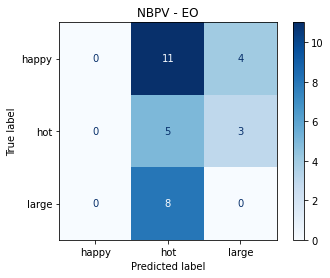

         AXL       AXL       AXL  ...       GZR       GZR       GZR
18  0.353651   0.31196  0.316561  ...  0.622305  0.608887  0.564672
96  0.877972  0.842174  0.903057  ...  0.584635  0.569175  0.557858
81  0.249638  0.317684  0.477767  ...   0.60134  0.594813  0.599399
79  0.501464   0.53095  0.592849  ...  0.622322  0.615051   0.61623
56  0.389432  0.392009  0.394844  ...  0.557817   0.60654  0.592681
..       ...       ...       ...  ...       ...       ...       ...
50  0.307364  0.308965  0.302828  ...  0.520841  0.530265  0.511417
40  0.672204  0.668151   0.67119  ...  0.585301  0.571573  0.547632
52  0.306066  0.305157  0.304249  ...  0.410221  0.374779  0.379674
26    0.3646  0.352475  0.300774  ...  0.598864  0.505684  0.321908
17  0.235214  0.235995   0.23658  ...  0.748202  0.769962  0.785116

[71 rows x 600 columns]
[[-0.15057265 -0.10503199 -0.2368431  ...  0.1917542  -0.07434671
  -0.24927531]
 [-0.16844935 -0.10133349 -0.15316014 ...  0.18602587 -0.0552853
  -0.27692184

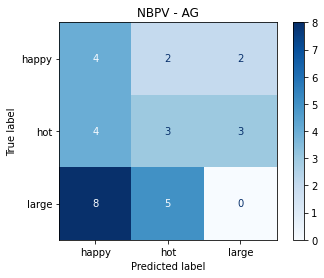

           AXL        AXL        AXL  ...       OYR       OYR       OYR
6     0.783958   0.799454   0.491113  ...  0.106061  0.106061  0.113636
42   0.0151061  0.0159301  0.0258174  ...     0.704     0.696     0.696
39    0.527312   0.539471   0.535611  ...  0.037594  0.037594  0.037594
50    0.307364   0.308965   0.302828  ...  0.507692  0.492308  0.492308
101   0.289939   0.309734   0.426409  ...  0.964286  0.964286  0.964286
..         ...        ...        ...  ...       ...       ...       ...
69    0.137697   0.152145   0.204903  ...  0.770492  0.770492  0.770492
51    0.292143   0.288584   0.291126  ...  0.461538  0.430769       0.4
61    0.351146    0.35039   0.360725  ...       0.4       0.4       0.4
87      0.4243   0.425486   0.420028  ...  0.541667      0.55     0.575
24    0.495158   0.497721   0.486328  ...  0.873418  0.962025         1

[71 rows x 600 columns]
[[ 0.24958306  0.65083506  0.03515234 -0.28386034 -0.04574701 -0.08774564]
 [ 0.25864418  0.64283551  0.0260802

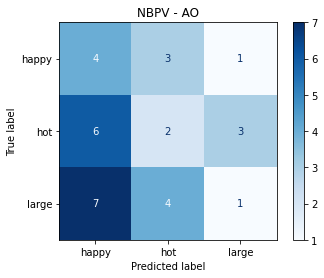

         GXL       GXL       GXL  ...        OYR        OYR        OYR
86  0.548646  0.516062  0.481643  ...   0.169231   0.184615        0.2
75  0.555956  0.540563  0.544862  ...          0  0.0225989  0.0338983
21  0.541249  0.467677  0.430891  ...   0.906977   0.891473   0.875969
81  0.611571  0.508555  0.583524  ...   0.918605   0.918605   0.918605
58  0.439744   0.44118  0.445097  ...   0.428571   0.428571   0.428571
..       ...       ...       ...  ...        ...        ...        ...
57  0.440221   0.44226  0.440941  ...   0.426667   0.426667   0.426667
33  0.893003  0.847078  0.718838  ...   0.985075   0.985075   0.985075
8   0.827895  0.809298  0.497357  ...       0.72   0.733333   0.733333
37  0.422904  0.441621   0.42439  ...  0.0162602  0.0162602  0.0162602
67  0.404583  0.403511  0.403913  ...    0.97191    0.97191    0.97191

[71 rows x 600 columns]
[[ 0.66757684 -0.29237704  0.14193626 ...  0.02804809  0.10051055
  -0.05177639]
 [ 0.66828554 -0.2933959   0.14113908 ... 

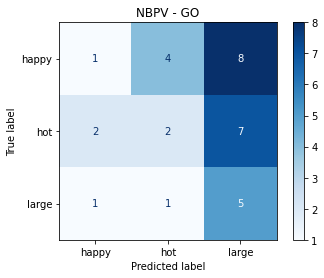

       EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
73   0.17869 -0.189564 -0.189714  ...  0.710931  0.706058  0.598626
58  0.142774 -0.151462 -0.140428  ...  0.463637  0.426818  0.432563
16  0.201208 -0.213452 -0.197902  ...  0.649341  0.676198  0.681179
30  0.186746  -0.19811 -0.183677  ...  0.421149  0.404046  0.415229
40  0.187485 -0.198894 -0.191524  ...  0.585301  0.571573  0.547632
..       ...       ...       ...  ...       ...       ...       ...
83  0.202349 -0.214662 -0.185909  ...  0.858617  0.777189  0.765756
12  0.196556 -0.208516 -0.178038  ...  0.475674  0.477452  0.476806
78  0.201953 -0.214242 -0.215749  ...  0.535652  0.492013  0.479177
93  0.159006 -0.168682  -0.16114  ...  0.239481  0.297117  0.388503
20  0.171057 -0.181466 -0.169788  ...  0.250608  0.283386  0.287694

[71 rows x 1400 columns]
[[-0.01994871  0.1185863   0.09484141 ... -0.11840406 -0.0568571
  -0.02019561]
 [-0.01527589  0.12989856  0.0943998  ... -0.0277641  -0.07481486
  -0.0178018

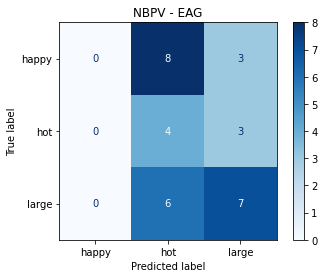

        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
20   0.171057 -0.181466 -0.169788  ...   0.888889   0.880952   0.873016
77   0.271226 -0.287731 -0.328219  ...   0.836364   0.845455   0.845455
100  0.140359 -0.148901 -0.162463  ...   0.907143   0.921429   0.928571
56   0.215348 -0.228453 -0.216205  ...   0.865922   0.871508   0.871508
96   0.151024 -0.160214 -0.159329  ...   0.960894   0.955307   0.955307
..        ...       ...       ...  ...        ...        ...        ...
74    0.17869 -0.189564 -0.192506  ...  0.0391061  0.0446927  0.0502793
61   0.146818 -0.155752 -0.144406  ...        0.4        0.4        0.4
9    0.183036 -0.194174 -0.184352  ...       0.75       0.75       0.75
81   0.176329 -0.187058 -0.170104  ...   0.918605   0.918605   0.918605
34   0.137459 -0.145824  -0.14225  ...   0.786517   0.786517   0.786517

[71 rows x 1400 columns]
[[-3.38477061e-01  1.76013225e-01  1.26827240e-01 ... -2.30263717e-02
   5.20396450e-02 -1.37262240e-04]
 [-3.

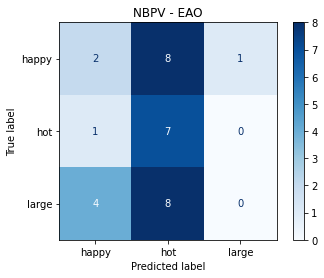

       EMG0L     EMG0L     EMG0L  ...        OYR        OYR       OYR
2    0.19041 -0.201997  -0.19556  ...   0.778846   0.769231  0.759615
76  0.179948 -0.190898  -0.21611  ...   0.794643   0.794643  0.803571
77  0.271226 -0.287731 -0.328219  ...   0.836364   0.845455  0.845455
97  0.174569 -0.185192 -0.168278  ...   0.955307   0.949721  0.944134
90  0.191454 -0.203104 -0.191299  ...      0.675   0.691667     0.725
..       ...       ...       ...  ...        ...        ...       ...
54  0.189353 -0.200876 -0.191291  ...   0.871508   0.865922  0.860335
27  0.199081 -0.211196  -0.19581  ...  0.0666667  0.0571429  0.047619
51   0.15179 -0.161027  -0.15291  ...   0.461538   0.430769       0.4
3   0.154958 -0.164387 -0.146129  ...   0.814815   0.796296  0.787037
42   0.19827 -0.210335 -0.204024  ...      0.704      0.696     0.696

[71 rows x 1400 columns]
[[-0.39026926 -0.06908217 -0.12896115 ... -0.06084726  0.03502463
   0.0392468 ]
 [-0.39403421 -0.06497247 -0.10838399 ... -0.05926267

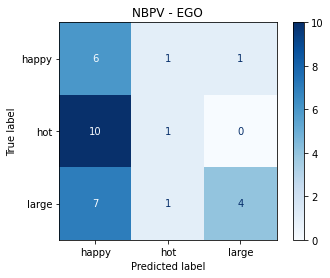

         AXL       AXL       AXL  ...       OYR       OYR       OYR
62  0.798156  0.799435  0.810179  ...         1         1  0.994413
40  0.672204  0.668151   0.67119  ...     0.016     0.016     0.016
29  0.135257  0.139073  0.131441  ...  0.144144  0.144144  0.144144
31         0  0.167355   0.23409  ...  0.971014  0.971014  0.971014
36  0.141005   0.14332  0.141237  ...  0.632812  0.632812  0.632812
..       ...       ...       ...  ...       ...       ...       ...
47  0.392769  0.402588  0.395893  ...  0.380952  0.380952  0.380952
93  0.383495  0.396633  0.400534  ...  0.546392  0.546392  0.546392
63  0.813243  0.814303  0.806886  ...         0         0         1
56  0.389432  0.392009  0.394844  ...  0.865922  0.871508  0.871508
94  0.409418  0.409418  0.335474  ...  0.505618  0.505618  0.505618

[71 rows x 900 columns]
[[-1.38614444e-01  1.09748015e-01  5.97990551e-01 ... -1.26398405e-02
   1.36005399e-03  8.21237622e-02]
 [-1.39704173e-01  1.10952734e-01  5.98797775e-01 ... 

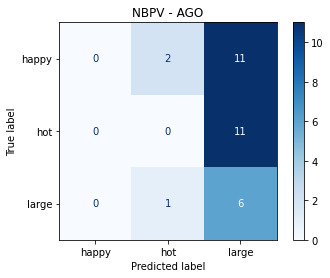

       EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
78  0.201953 -0.214242 -0.215749  ...   0.820755   0.830189   0.830189
39  0.150609 -0.159773  -0.15498  ...   0.037594   0.037594   0.037594
81  0.176329 -0.187058 -0.170104  ...   0.918605   0.918605   0.918605
64  0.194372   -0.2062 -0.193362  ...   0.966292   0.966292   0.966292
36  0.167158  -0.17733 -0.170602  ...   0.632812   0.632812   0.632812
..       ...       ...       ...  ...        ...        ...        ...
72  0.184077 -0.195279 -0.193223  ...   0.921348   0.955056          1
49  0.203788 -0.216189 -0.148847  ...   0.391304   0.391304   0.391304
30  0.186746  -0.19811 -0.183677  ...  0.0860215  0.0752688  0.0645161
46  0.210227 -0.223019 -0.184348  ...  0.0136986  0.0136986  0.0136986
19  0.251746 -0.267065 -0.247609  ...      0.864      0.848       0.84

[71 rows x 1700 columns]
[[-0.15859444 -0.29018342 -0.03080378 ...  0.0788681   0.08719795
   0.02488681]
 [-0.15826353 -0.27118349 -0.01414055 ...

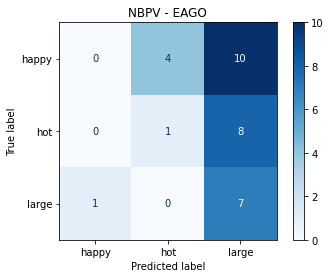

         EMG0L       EMG0L       EMG0L  ...      EMG7R      EMG7R     EMG7R
1    0.0269607  -0.0286013   -0.288099  ...  -0.129313   0.719581  0.130594
22  0.00365358 -0.00387591 -0.00359355  ...  0.0253374  -0.906545 -0.423914
90   0.0296039  -0.0314053  -0.0727729  ...    0.29704   0.281571 -0.172494
97  0.00740057  -0.0078509   0.0292671  ...  0.0141057   -1.14579   2.34315
62   0.0199706  -0.0211859  -0.0196425  ...  -0.299849  -0.596215 -0.917139
..         ...         ...         ...  ...        ...        ...       ...
13   0.0414224   -0.043943   0.0308304  ...  0.0386253   0.925742  0.678307
47   0.0256998  -0.0272636     0.15273  ...    3.62545   -2.27078  -0.72773
36   0.0198525  -0.0210605   -0.106076  ...  -0.691135   -1.65795   -1.9102
96   0.0264286  -0.0280368   -0.145897  ...   -1.88838  -0.431116  0.181969
68   0.0592885  -0.0628963   -0.468379  ...   0.125025  0.0224541  0.317488

[71 rows x 800 columns]
[[-1.37048129  0.00301813 -0.02369234 ... -0.23901457 -0.201286

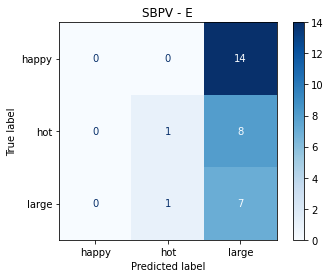

         AXL       AXL        AXL  ...       AZR       AZR       AZR
62  0.764432  0.770541    0.82187  ...   1.42315   1.69202   1.68469
68  -1.43477  -1.42176   -1.40504  ...  0.907991   1.11142   1.12722
47 -0.773836 -0.728724  -0.759482  ...   1.37407   1.37407   1.38434
44  -1.18853  -1.20715   -1.17075  ...   1.30503   1.32027   1.28303
89 -0.738949 -0.216226  -0.346168  ...   1.20723   1.50551   1.58329
..       ...       ...        ...  ...       ...       ...       ...
0   -2.03773  -2.65004   -1.41895  ...  0.951655  0.901709  0.964605
46  -1.03145  -1.03917    -1.0138  ...   1.44553   1.26246   1.40804
40  0.502739  0.483866    0.49802  ...   1.13304   1.32176   1.37649
91 -0.921533   -1.0875  -0.416143  ...  0.734348   1.19942   1.14223
88  -0.11358 -0.149508  0.0950052  ...   1.20579   1.16986   1.14991

[71 rows x 300 columns]
[[ 1.28929535  2.64441748 -0.60497754  0.67980877]
 [ 1.28492545  2.64645982 -0.60312092  0.65915725]
 [ 1.26822207  2.71089351 -0.61181907  0.6620

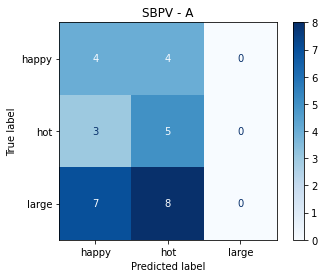

            GXL         GXL        GXL  ...         GZR        GZR        GZR
47   -0.0975245  0.00470025   -0.18171  ...  -0.0644518 -0.0584386  -0.055432
45    -0.033561  -0.0912101 -0.0657766  ...  0.00543697 -0.0539077 -0.0454299
101    0.985225     1.02237    1.70965  ...    0.407253   0.308662 -0.0271194
38   -0.0265204 -0.00531177  -0.063282  ...   -0.215984  -0.107113  0.0102412
30    -0.629111     -1.0384   -1.32244  ...   -0.428055   -0.51103  -0.456777
..          ...         ...        ...  ...         ...        ...        ...
55   -0.0936617   -0.125327  -0.126911  ...    0.802475    0.26416 -0.0524964
24      0.14137    0.139689  -0.179773  ...     1.76727    2.96944    1.10144
16   0.00417983  0.00889365  -0.566192  ...   0.0583887   0.204517   0.231621
72     0.759456   -0.264971  -0.325543  ...     3.02939    2.12687    2.03298
27    -0.975619   -0.660253  -0.847246  ...   -0.489584  -0.378278  -0.346371

[71 rows x 300 columns]
[[-0.6747504  -0.39564747  0.08357492 -

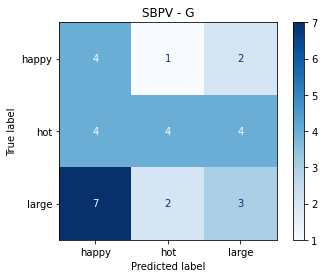

          ORL       ORL       ORL  ...       OYR       OYR       OYR
23  -0.633069 -0.633069 -0.725487  ...   1.26152    1.1691   1.07668
32  -0.445888 -0.418477 -0.418477  ...   1.96629   1.96629   1.96629
56  -0.954621 -0.954621 -0.983384  ...   1.63399   1.66275   1.66275
3   -0.426942 -0.426942 -0.426942  ...   1.53462   1.46197   1.42564
101 -0.455072 -0.427096 -0.287218  ...    2.1187    2.1187    2.1187
..        ...       ...       ...  ...       ...       ...       ...
74  -0.344487 -0.318323 -0.318323  ...  -2.38524  -2.35908  -2.33292
48   0.459311  0.459311  0.459311  ...  -1.73785  -1.73785  -1.73785
59  -0.530598 -0.530598  -0.48567  ... -0.171175 -0.171175 -0.171175
8   -0.603297 -0.545026 -0.545026  ...  0.329036  0.387307  0.387307
60   -0.45859  -0.45859  -0.45859  ... -0.192226 -0.192226 -0.192226

[71 rows x 300 columns]
[[-0.641629   -1.40194455  0.72105289  0.06156511]
 [-0.63485553 -1.42049191  0.73706651  0.02387876]
 [-0.58916516 -1.53770641  0.90491992 -0.1335

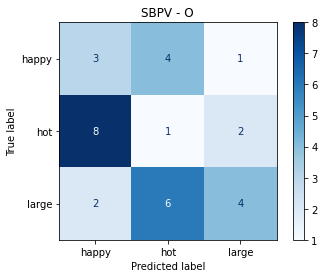

        EMG0L      EMG0L      EMG0L  ...       AZR       AZR       AZR
79  0.0218862 -0.0232181    1.24929  ...   0.97165  0.981882  0.982735
87  0.0117786 -0.0124953   0.120203  ...  0.954299  0.989205    1.1841
33  0.0488545 -0.0518273  0.0560786  ...   1.08759   1.11172   1.12418
86  0.0298482 -0.0316645  -0.126524  ...   1.11719    1.1198   1.12242
24   0.031879 -0.0338189 -0.0529133  ...   1.36429   1.84884   1.73856
..        ...        ...        ...  ...       ...       ...       ...
75  0.0377271 -0.0400228  -0.605832  ...   1.80736      1.85   1.88445
42  0.0526778 -0.0558833  -0.163595  ...   1.80368   1.74341   1.39056
99  0.0421715 -0.0447377   0.361026  ...  0.975855  0.942934   1.00255
69  0.0528559 -0.0560722   0.212528  ...   1.00928  0.969919  0.975286
93  0.0317341 -0.0336652 -0.0853434  ...   1.54793   1.44761    1.6388

[71 rows x 1100 columns]
[[-0.11842692  0.45989262 -0.0654907  ... -0.45018317  0.32743975
   0.20248145]
 [ 0.0194093   0.52807696 -0.52377208 ...

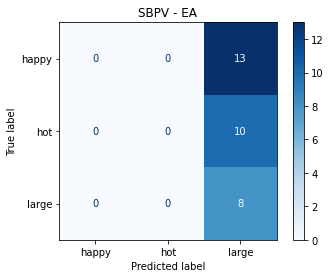

         EMG0L       EMG0L       EMG0L  ...         GZR        GZR        GZR
8      0.02564  -0.0272003    -0.15362  ...    0.316716   0.156804  0.0763455
55   0.0258381  -0.0274103   -0.087862  ...    0.802475    0.26416 -0.0524964
58    0.013389  -0.0142038   -0.013169  ...    0.143056  -0.180593  -0.130095
39    0.034875  -0.0369972   -0.135634  ...   -0.053632 -0.0863234  -0.116291
48    0.029955  -0.0317778   0.0269231  ... -0.00658662 -0.0120717 -0.0230418
..         ...         ...         ...  ...         ...        ...        ...
49   0.0156336   -0.016585    0.574572  ...  -0.0252434   -0.02065 -0.0160566
70   0.0509311  -0.0540304   0.0693923  ...   0.0365675  0.0382871   0.003895
32   0.0119981  -0.0127282   0.0565155  ...  -0.0931163  -0.106309   -0.10254
6   0.00933139 -0.00989921   -0.061842  ...   0.0344663  0.0418761   0.151965
22  0.00365358 -0.00387591 -0.00359355  ...     -1.2408   -1.16223   -1.16507

[71 rows x 1100 columns]
[[ 0.77522249 -0.04086698  0.50235901 

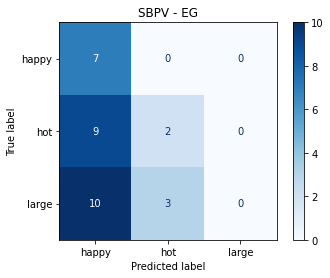

        EMG0L       EMG0L       EMG0L  ...       OYR       OYR       OYR
44  0.0444205  -0.0471235  -0.0900827  ...  0.843806  0.843806  0.843806
88  0.0221293  -0.0234759  0.00275433  ...   0.94634   1.06828   1.15973
55  0.0258381  -0.0274103   -0.087862  ...   1.69979   1.69979   1.69979
1   0.0269607  -0.0286013   -0.288099  ...   1.28512   1.28512   1.24819
91  0.0487721  -0.0517399  -0.0479706  ...   0.15615   0.15615  0.110133
..        ...         ...         ...  ...       ...       ...       ...
29  0.0403627  -0.0428188  -0.0396995  ...  -1.45159  -1.45159  -1.45159
30  0.0153445  -0.0162782  -0.0150924  ...  -1.76244    -1.804  -1.84556
52   0.019366  -0.0205445  -0.0401264  ... -0.447381 -0.561073 -0.674766
89 -0.0029585  0.00313853    0.203865  ...    1.0905   1.18008    1.2398
61  0.0254939  -0.0270452   -0.025075  ... -0.230687 -0.230687 -0.230687

[71 rows x 1100 columns]
[[ 1.24028977e+00 -2.38065769e-01 -7.26112471e-03 ... -1.03990468e+00
   2.01266174e-02  3.7398229

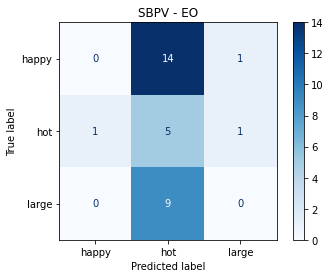

         AXL       AXL        AXL  ...         GZR        GZR        GZR
29  -1.42462  -1.40966   -1.43958  ...   -0.377415  -0.162205  -0.231008
8   -1.62666  -1.66829   -3.61046  ...    0.316716   0.156804  0.0763455
21 -0.265531 -0.264645  -0.274389  ...     -1.1039   -1.13621   -1.21791
34  -1.33558  -1.30345   -1.31648  ...   -0.112534  -0.107614 -0.0571836
11 -0.938534 -0.409902  -0.165491  ... -0.00147776  0.0158322  0.0148705
..       ...       ...        ...  ...         ...        ...        ...
92 -0.395356 -0.272837 -0.0705389  ...   -0.550735  -0.259138  -0.270875
19 -0.531941 -0.524887  -0.534587  ...      -1.402   -1.43339   -1.38336
55 -0.417929 -0.414447  -0.423152  ...    0.802475    0.26416 -0.0524964
71   -1.7783  -1.73852   -1.04989  ...  -0.0932119 -0.0588051 -0.0445388
26  -0.64008  -0.70292  -0.970863  ...     0.71436   0.246838  -0.675241

[71 rows x 600 columns]
[[-0.02225018 -0.33122879  0.10122911 ...  0.05315355  0.87027017
   0.48608045]
 [-0.02333191 -0.3

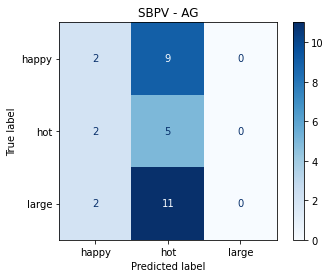

         AXL       AXL       AXL  ...        OYR        OYR        OYR
38  0.405084  0.448695  0.428343  ...   -1.93481   -1.96662   -1.96662
65  -1.11748   -1.0891  -1.14754  ...    1.95426    1.95426    1.92922
52 -0.453628 -0.456863 -0.460098  ...  -0.447381  -0.561073  -0.674766
59 -0.754113 -0.754113 -0.705051  ...  -0.171175  -0.171175  -0.171175
45  -1.04281  -1.05946  -1.05724  ...   -2.36596   -2.36596   -2.36596
..       ...       ...       ...  ...        ...        ...        ...
5   0.790333  0.692859 -0.132986  ...   -1.97271   -1.97271   -1.97271
16  -0.61941 -0.616025 -0.781907  ... -0.0319721 -0.0319721 -0.0319721
77  -1.58131  -1.62752   -1.8335  ...    1.25442    1.28988    1.28988
13  0.471031  0.175567 -0.694616  ...  -0.614014  -0.614014   -0.67513
22 -0.520068 -0.488763 -0.440935  ...     1.9869    1.93084    1.90281

[71 rows x 600 columns]
[[ 1.6050548   2.04873148  1.01308347 -0.3130383  -0.05106008 -0.49430335]
 [ 1.60592916  2.04746632  1.03361189 -0.3298485

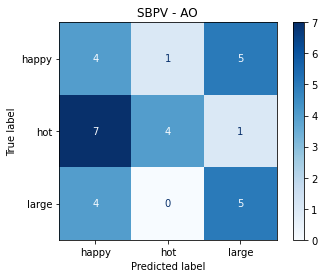

            GXL         GXL        GXL  ...       OYR       OYR       OYR
8       1.41297     1.31038  -0.410431  ...  0.329036  0.387307  0.387307
97    -0.135245   -0.161239   0.405812  ...   2.03727   2.00964     1.982
54     0.016263  -0.0288541 -0.0739712  ...   1.65522   1.62619   1.59716
39 -0.000508461 -0.00731917  0.0158372  ...  -1.91271  -1.91271  -1.91271
94   -0.0722838  -0.0722838   -1.32956  ...  0.113696  0.113696  0.113696
..          ...         ...        ...  ...       ...       ...       ...
4      0.224163    -1.43292   -1.06776  ...  -1.92214  -1.92214  -1.92214
6      0.872834   -0.486338   0.869658  ...  -1.85773  -1.85773  -1.82608
84     -1.05068   0.0909842  -0.359834  ...  -1.30895  -1.23315  -1.23315
9      0.509761    0.367686    1.02572  ...  0.495261  0.495261  0.495261
76     0.827612     1.18969    1.00905  ...   1.03812   1.03812   1.07137

[71 rows x 600 columns]
[[ 0.21688951 -0.14814774  0.44834381 ...  1.24161971 -0.16347965
  -1.42395665]
 [ 0.1

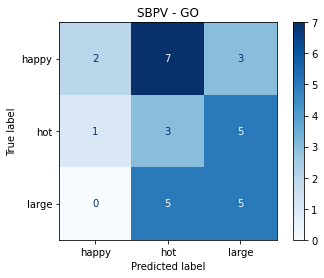

          EMG0L        EMG0L      EMG0L  ...        GZR        GZR        GZR
28  0.000389421 -0.000413117  -0.072276  ...  -0.486176   -0.37483  -0.324364
95    0.0258403   -0.0274127  0.0117646  ...   0.697121   0.440087   0.339957
52     0.019366   -0.0205445 -0.0401264  ...  -0.675218  -0.980805  -0.938596
25    0.0193365   -0.0205131   0.036726  ...    2.45102   0.859235    1.07192
56    0.0140799   -0.0149367 -0.0851394  ...   0.663334    1.03532    0.92951
..          ...          ...        ...  ...        ...        ...        ...
10    0.0109608    0.0362884  -0.205361  ...   -0.10119  -0.117258  -0.126632
76    0.0687636   -0.0729479   -0.51524  ...  0.0215695  0.0954299  0.0496686
64    0.0472768   -0.0501537 -0.0958753  ...   -0.08494 -0.0347835 -0.0690367
50    0.0253906   -0.0269357 -0.0538264  ...  0.0133903   0.106229 -0.0794484
18    0.0333779    -0.035409 -0.0328294  ...   0.374923   0.300171  0.0538547

[71 rows x 1400 columns]
[[-0.69081265  0.03695636  0.23391689 

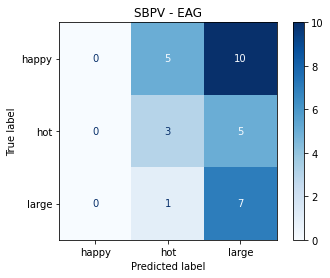

        EMG0L      EMG0L      EMG0L  ...      OYR      OYR       OYR
54  0.0511171 -0.0542277  -0.125449  ...  1.65522  1.62619   1.59716
90  0.0296039 -0.0314053 -0.0727729  ...  1.02566  1.08557   1.20539
91  0.0487721 -0.0517399 -0.0479706  ...  0.15615  0.15615  0.110133
56  0.0140799 -0.0149367 -0.0851394  ...  1.63399  1.66275   1.66275
5  -0.0109027  0.0115662    0.13975  ... -1.97271 -1.97271  -1.97271
..        ...        ...        ...  ...      ...      ...       ...
31  0.0168648 -0.0178911   0.246241  ...  2.03416  2.03416   2.03416
40  0.0416108 -0.0441428  -0.138452  ... -1.99894 -1.99894  -1.99894
62  0.0199706 -0.0211859 -0.0196425  ...  1.94132  1.94132   1.91985
1   0.0269607 -0.0286013  -0.288099  ...  1.28512  1.28512   1.24819
32  0.0119981 -0.0127282  0.0565155  ...  1.96629  1.96629   1.96629

[71 rows x 1400 columns]
[[ 0.22381733 -1.10577953  1.65797279 ...  0.18599046 -0.11184132
   0.08324097]
 [-0.22522731 -1.11465455  0.42755321 ...  0.13764923 -0.01650408

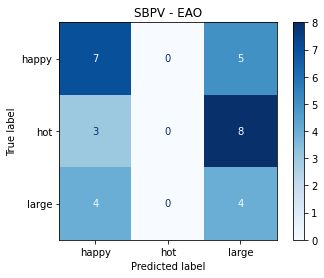

         EMG0L       EMG0L       EMG0L  ...       OYR       OYR       OYR
40   0.0416108  -0.0441428   -0.138452  ...  -1.99894  -1.99894  -1.99894
90   0.0296039  -0.0314053  -0.0727729  ...   1.02566   1.08557   1.20539
56   0.0140799  -0.0149367  -0.0851394  ...   1.63399   1.66275   1.66275
17   0.0527119  -0.0559194  -0.0518457  ... -0.377771 -0.377771 -0.377771
37    0.026641   -0.129032    0.156276  ...  -1.95251  -1.95251  -1.95251
..         ...         ...         ...  ...       ...       ...       ...
82 -0.00917987  0.00973848   -0.380052  ...   1.64941   1.64941   1.64941
38   0.0332021  -0.0352225 -0.00515995  ...  -1.93481  -1.96662  -1.96662
81   0.0304616  -0.0323152   0.0161492  ...   1.71286   1.71286   1.71286
52    0.019366  -0.0205445  -0.0401264  ... -0.447381 -0.561073 -0.674766
44   0.0444205  -0.0471235  -0.0900827  ...  0.843806  0.843806  0.843806

[71 rows x 1400 columns]
[[-0.74549624  1.79054203 -1.34471653 ...  0.1892855   0.37528946
   0.12037721]
 [-0.

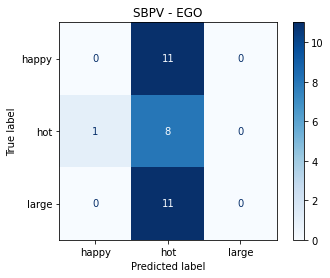

         AXL       AXL       AXL  ...       OYR       OYR       OYR
83 -0.642468 -0.615532 -0.740654  ...  -1.31138  -1.24009  -1.24009
6   0.965165   1.03539 -0.361854  ...  -1.85773  -1.85773  -1.82608
87 -0.718282 -0.713434 -0.735735  ...  0.548612  0.579147  0.670752
2   -1.79295  -1.75521  -2.08358  ...   1.39445   1.35818   1.32191
34  -1.33558  -1.30345  -1.31648  ...   1.27895   1.27895   1.27895
..       ...       ...       ...  ...       ...       ...       ...
17 -0.688189 -0.684973 -0.682563  ... -0.377771 -0.377771 -0.377771
36  -1.32384   -1.3153  -1.32299  ...  0.919255  0.919255  0.919255
60  -0.72502 -0.721518 -0.676872  ... -0.192226 -0.192226 -0.192226
42  -1.24802   -1.2454  -1.21396  ...  0.696832  0.659943  0.659943
8   -1.62666  -1.66829  -3.61046  ...  0.329036  0.387307  0.387307

[71 rows x 900 columns]
[[-2.66071358 -0.0942162  -1.35255237 ... -0.27407311  0.28189607
   0.30520694]
 [-2.66169378 -0.06027372 -1.35948946 ... -0.14531153  0.4275148
   0.32145708

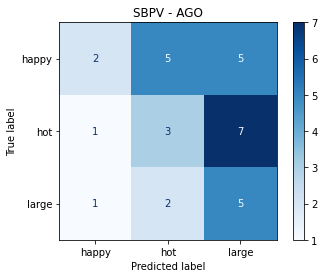

          EMG0L        EMG0L      EMG0L  ...       OYR       OYR       OYR
28  0.000389421 -0.000413117  -0.072276  ...  -1.61801  -1.65713  -1.69625
35    0.0601224   -0.0637809  -0.100244  ...   1.14744   1.11782   1.11782
81    0.0304616   -0.0323152  0.0161492  ...   1.71286   1.71286   1.71286
39     0.034875   -0.0369972  -0.135634  ...  -1.91271  -1.91271  -1.91271
93    0.0317341   -0.0336652 -0.0853434  ...  0.202699  0.202699  0.202699
..          ...          ...        ...  ...       ...       ...       ...
89   -0.0029585   0.00313853   0.203865  ...    1.0905   1.18008    1.2398
69    0.0528559   -0.0560722   0.212528  ...   1.27875   1.27875   1.27875
33    0.0488545   -0.0518273  0.0560786  ...   2.04065   2.04065   2.04065
25    0.0193365   -0.0205131   0.036726  ...   1.36774   1.41307   1.41307
77    0.0533429   -0.0565889   -1.06936  ...   1.25442   1.28988   1.28988

[71 rows x 1700 columns]
[[-0.8390435  -3.31482812  0.63564171 ...  0.15204137  0.13200682
  -0.541

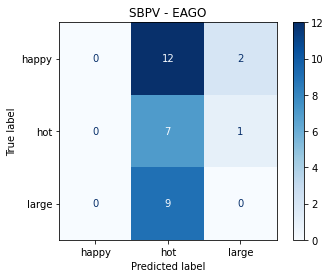

In [12]:
for st in steps:
  rownum+=1
  columnnum=-1
  for pr in regproducts:
    columnnum+=1
    combo=nsteps[rownum]+' - '+comb[columnnum]
    words=set(pr['Word']) # Obtain the target names for the SVM
    
    # First step: set input matrix as regular, normalized or standardized
    input_matrix=pr
    if st%3==0: # Normalization
      input_matrix=normproducts[columnnum]
    if st%5==0: # Standardization
      input_matrix=stanproducts[columnnum]
    
    # Second step: apply Butterworth
    two_matrix=input_matrix
    if st%7==0: # Butterworth
      two_matrix=butterworth(input_matrix)
    
    # Third step: split data for later steps
    x_train, x_test, y_train, y_test=datasplit(two_matrix)
    
    # Fourth step: apply PCA
    x_t_train=x_train
    x_t_test=x_test
    if st%11==0: # PCA
      x_train, x_test, y_train, y_test, x_t_train, x_t_test=pca(x_train, x_test, y_train, y_test)
    
    # Fifth step: apply SVM
    if st%13==0: # SVM
      #svmresults,accuracy,par=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
      svmresults,accuracy=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
    
    #print('The best parameters for',combo,'are:',par)
    fresults[rownum,columnnum]=accuracy*100
fresults=pd.DataFrame(fresults,index=nsteps,columns=comb)
exec("fresults.to_csv(path_or_buf='/content/results_'+str(numreps)+'.csv')")

endtime=time.time()

# **5. Results**

In [13]:
print(fresults)
print('The maximum accuracy for',numreps,'repetitions is',fresults.max().max())
print('The program executed in '+str(endtime-starttime)+' seconds')

              E          A          G  ...        EGO        AGO       EAGO
V     36.916667  63.083333  73.833333  ...  74.083333  84.583333  48.166667
NV    11.000000  44.250000  84.583333  ...  48.416667  63.083333  74.083333
SV    48.166667  18.833333  62.833333  ...  48.166667  70.666667  59.166667
BV    30.083333  47.916667  77.750000  ...  77.500000  59.666667  52.333333
PV    11.250000  36.916667  47.916667  ...  29.583333  33.500000  29.833333
NBV   47.916667  40.583333  63.333333  ...  44.500000  55.750000  22.500000
NPV   36.666667  40.333333  40.583333  ...  40.833333  40.583333  29.833333
SBV   33.250000  55.500000  70.416667  ...  59.166667  67.000000  66.500000
SPV   41.083333  33.000000  48.416667  ...  55.000000  40.333333  47.916667
BPV   33.250000  47.916667  47.916667  ...  14.666667  14.666667  15.166667
NBPV  44.000000  33.250000  29.833333  ...  11.250000  29.583333  41.083333
SBPV  47.916667  48.166667  26.166667  ...  18.333333  30.083333  44.500000

[12 rows x 